# 0. Import libraries

In [1]:
!pip install pandas -q
!pip install numpy -q
!pip install geopy -q
!pip install matplotlib -q
!pip install seaborn -q
!pip install scikit-learn -q

In [2]:
import pandas as pd
import numpy as np
import geopy.distance
import matplotlib.pyplot as plt
import sklearn
from matplotlib import colors
from scipy.stats import zscore

# 1. Load data

- upload the dataset

In [3]:
train_df = pd.read_csv('data/train.csv')
test_df = pd.read_csv('data/test.csv')
poi_df = pd.read_csv('data/poi.csv')

/tmp/ipykernel_26650/4245473066.py:3: DtypeWarning: Columns (7,9,11,13,17,18,19,22,23,24,25,26,28,29,30,32,33,34,35,36,37,38,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,74,77,80,82,83,84,85,86,87,90,91,92,95) have mixed types. Specify dtype option on import or set low_memory=False.
  poi_df = pd.read_csv('data/poi.csv')


# 2. Add Features

In [4]:
def NaN_analysis(df):
    # analysis1: percentage of NaN values in columns
    d = {'column': [], 'n_nan': [], 'percentage': []}
    for col in df.columns:
        n_nan = df[(df[col].isna()) | (df[col].isnull())].shape[0]
        d['column'].append(col)
        d['n_nan'].append(n_nan)
        d['percentage'].append((n_nan*100)/df.shape[0])
    analysis1 = pd.DataFrame(d).sort_values('percentage', ascending=False).reset_index(drop=True)
    # analysis2: number of NaN values in each row grouped by number of NaN values
    d = {'n_nan': [], 'n_rows': []}
    for n_nan in range(1, df.shape[1]+1):
        n_rows = df[df.isna().sum(axis=1) == n_nan].shape[0]
        d['n_nan'].append(n_nan)
        d['n_rows'].append(n_rows)
    analysis2 = pd.DataFrame(d).sort_values('n_nan', ascending=False).reset_index(drop=True)
    return analysis1, analysis2

In [5]:
analysis1, analysis2 = NaN_analysis(poi_df)

In [6]:
analysis1

column   n_nan  percentage
0        tags.alt_name:gl  397381   99.999748
1     tags.source:name:oc  397381   99.999748
2      tags.name:east2276  397381   99.999748
3            tags.name:za  397381   99.999748
4          tags.ref:ISTAT  397380   99.999497
..                    ...     ...         ...
91  tags.addr:housenumber  292834   73.690806
92                    lon       0    0.000000
93                 source       0    0.000000
94                    lat       0    0.000000
95         id_on_platform       0    0.000000

[96 rows x 3 columns]

In [7]:
analysis2

n_nan  n_rows
0      96       0
1      95       0
2      94       0
3      93       0
4      92  106013
..    ...     ...
91      5       0
92      4       0
93      3       0
94      2       0
95      1       0

[96 rows x 2 columns]

We want to add to our dataset the feature number of point of interest. By running the NaN analysis we notice that the only columns that we can use are lat and lon, the others are mainly composed by NaNs. 

The data of the new feature will be the mean of the distances between each house and its closest point of interest. 

In [8]:
poi_df

id_on_platform        lat       lon             source tags.addr:city   
0             21225803  45.460632  9.190908  openstreetmap.org            NaN  \
1             21225957  45.460992  9.191615  openstreetmap.org            NaN   
2             21225987  45.462431  9.193959  openstreetmap.org            NaN   
3             21226001  45.460820  9.191105  openstreetmap.org            NaN   
4             21226174  45.468803  9.199262  openstreetmap.org            NaN   
...                ...        ...       ...                ...            ...   
397377      9844153599  46.218665  6.148755  openstreetmap.org            NaN   
397378      9844156332  46.222237  6.097440  openstreetmap.org            NaN   
397379      9844156333  46.221761  6.097105  openstreetmap.org            NaN   
397380      9844156334  46.225913  6.101458  openstreetmap.org            NaN   
397381      9844191652  46.223206  6.098372  openstreetmap.org            NaN   

       tags.addr:country tags.addr:housenumber tags.addr:postcode   
0                    NaN                   NaN                NaN  \
1                    NaN                   NaN                NaN   
2                    NaN                   NaN                NaN   
3                    NaN                   NaN                NaN   
4                    NaN                   NaN                NaN   
...                  ...                   ...                ...   
397377               NaN                   NaN                NaN   
397378               NaN                   NaN                NaN   
397379               NaN                   NaN                NaN   
397380               NaN                   NaN                NaN   
397381               NaN                   NaN                NaN   

       tags.addr:street tags.alt_name:gl  ... tags.subway tags.survey:date   
0                   NaN              NaN  ...         NaN              NaN  \
1                   NaN              NaN  ...         NaN              NaN   
2                   NaN              NaN  ...         NaN              NaN   
3                   NaN              NaN  ...         NaN              NaN   
4                   NaN              NaN  ...         NaN              NaN   
...                 ...              ...  ...         ...              ...   
397377              NaN              NaN  ...         NaN              NaN   
397378              NaN              NaN  ...         NaN              NaN   
397379              NaN              NaN  ...         NaN              NaN   
397380              NaN              NaN  ...         NaN              NaN   
397381              NaN              NaN  ...         NaN              NaN   

       tags.tactile_paving tags.tourism tags.traffic_calming tags.train   
0                      NaN          NaN                  NaN        NaN  \
1                      NaN          NaN                  NaN        NaN   
2                      NaN          NaN                  NaN        NaN   
3                      NaN          NaN                  NaN        NaN   
4                      NaN          NaN                  NaN        NaN   
...                    ...          ...                  ...        ...   
397377                 NaN          NaN               island        NaN   
397378                 NaN          NaN               island        NaN   
397379                 NaN          NaN               island        NaN   
397380                 NaN          NaN               island        NaN   
397381                 NaN          NaN               island        NaN   

       tags.tram tags.wheelchair tags.wikidata tags.wikipedia  
0            NaN             NaN           NaN            NaN  
1            NaN             NaN           NaN            NaN  
2            NaN             NaN           NaN            NaN  
3            NaN             NaN           NaN            NaN  
4            NaN             NaN           NaN  

In [9]:
poi_df = poi_df[['lat', 'lon']]

In [10]:
def get_n_poi(lat, lon, poi_df, radius=0.003):
    # radius = 0.03 -> 3km
    # get all poi in a certain radius from the current lat and lon
    series = poi_df[(poi_df['lat']-lat)**2 + (poi_df['lon']-lon)**2 <= radius**2]
    # n_poi = np.nan if series.shape[0] == 0 else series.shape[0]
    return series.shape[0] # n_poi

<Axes: >

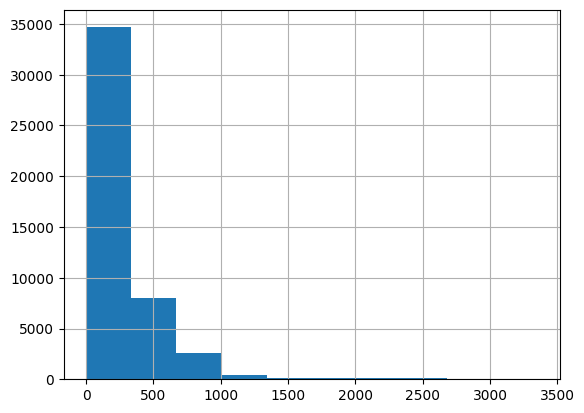

In [11]:
train_df['n_poi'] = train_df.apply(lambda x: get_n_poi(x['latitude'], x['longitude'], poi_df), axis=1)
train_df['n_poi'].hist()

# 3. Fill NaNs

- check which entries are incorrect for some features and then fix or drop the entries (correctness)
- solve the NaN, for each case decide if we fix or drop (completeness)
- finally we can obtein the clean dataset, with which we can start to work and analyse it in step 2

In [12]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46312 entries, 0 to 46311
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   46312 non-null  int64  
 1   price                46312 non-null  int64  
 2   balcony              30869 non-null  object 
 3   conditions           45083 non-null  object 
 4   construction_year    32366 non-null  float64
 5   latitude             46299 non-null  float64
 6   longitude            46299 non-null  float64
 7   energy_efficiency    26409 non-null  float64
 8   expenses             30158 non-null  float64
 9   floor                44281 non-null  float64
 10  garden               14783 non-null  object 
 11  n_bathrooms          43896 non-null  float64
 12  elevator             28869 non-null  float64
 13  total_floors         27963 non-null  float64
 14  n_rooms              45959 non-null  float64
 15  proximity_to_center  46299 non-null 

In [13]:
train_df

id   price balcony               conditions  construction_year   
0      10461   60000    True  Buono stato / Abitabile             1980.0  \
1      51304  900000     NaN  Buono stato / Abitabile                NaN   
2      33032   33000     NaN  Buono stato / Abitabile             1960.0   
3      62281  166000     NaN   Ottimo / Ristrutturato                NaN   
4      45681  410000    True  Buono stato / Abitabile                NaN   
...      ...     ...     ...                      ...                ...   
46307  33085  329999    True  Buono stato / Abitabile             1929.0   
46308  17403  599000    True         Da ristrutturare             1920.0   
46309  33332  549000    True  Buono stato / Abitabile                NaN   
46310  63367  189000    True  Buono stato / Abitabile             1965.0   
46311  27322  355000    True   Ottimo / Ristrutturato             1970.0   

        latitude  longitude  energy_efficiency  expenses  floor garden   
0      41.901300  12.700000             175.00      30.0    2.0    NaN  \
1      41.907017  12.481311                NaN       NaN    3.0    NaN   
2      41.976500  12.440500             204.20      30.0    4.0    NaN   
3      45.484800  12.198200             175.00       NaN    1.0   True   
4      45.424480  12.328622              65.91       NaN    3.0    NaN   
...          ...        ...                ...       ...    ...    ...   
46307  41.923500  12.446100             175.00      35.0    3.0    NaN   
46308  41.916743  12.454925                NaN     170.0    6.0    NaN   
46309  45.454701   9.242711                NaN       NaN    NaN    NaN   
46310  45.445605   9.245942                NaN     150.0   -1.0   True   
46311  41.877000  12.431400             175.00     100.0    1.0    NaN   

       n_bathrooms  elevator  total_floors  n_rooms  proximity_to_center   
0              1.0       NaN           3.0      1.0              1.00000  \
1              1.0       1.0           NaN      3.0              1.00000   
2              1.0       NaN           4.0      1.0              1.00000   
3              1.0       NaN           1.0      2.0              0.99205   
4              2.0       1.0           NaN      3.0              1.00000   
...            ...       ...           ...      ...                  ...   
46307          1.0       NaN           4.0      3.0              1.00000   
46308          2.0       1.0           NaN      5.0              1.00000   
46309          2.0       1.0           NaN      3.0              1.00000   
46310          1.0       1.0           NaN      3.0              1.00000   
46311          1.0       1.0           5.0      4.0              1.00000   

       surface  n_poi  
0         35.0      0  
1        131.0    191  
2         16.0      0  
3        100.0      0  
4         90.0    105  
...        ...    ...  
46307     88.0     83  
46308    189.0    247  
46309    140.0    243  
46310     70.0    223  
46311    101.0     20  

[46312 rows x 18 columns]

We start by making an anysis of the NaN.

In [14]:
analysis1, analysis2 = NaN_analysis(train_df)

In [15]:
analysis1

column  n_nan  percentage
0                garden  31529   68.079547
1     energy_efficiency  19903   42.975903
2          total_floors  18349   39.620401
3              elevator  17443   37.664104
4              expenses  16154   34.880808
5               balcony  15443   33.345569
6     construction_year  13946   30.113146
7           n_bathrooms   2416    5.216790
8                 floor   2031    4.385472
9            conditions   1229    2.653740
10              surface    443    0.956556
11              n_rooms    353    0.762221
12  proximity_to_center     13    0.028070
13             latitude     13    0.028070
14            longitude     13    0.028070
15                   id      0    0.000000
16                price      0    0.000000
17                n_poi      0    0.000000

In [16]:
analysis2

n_nan  n_rows
0      18       0
1      17       0
2      16       0
3      15       0
4      14       0
5      13       0
6      12       1
7      11       3
8      10     172
9       9     147
10      8     536
11      7    1295
12      6    3230
13      5    5605
14      4    6704
15      3    7330
16      2    8784
17      1    9058

In [17]:
# drop id
train_df.drop('id', axis=1, inplace=True)

In [18]:
def groupby_count_percentage(df, col):
    tmp = df[col].to_frame()
    tmp.fillna('NaN', inplace=True)
    tmp['count'] = 0
    tmp = tmp.groupby(col).count().reset_index().sort_values('count', ascending=False).reset_index(drop=True)
    tmp['percentage'] = (tmp['count']*100)/df.shape[0]
    return tmp

We can notice that for the features balcony and garden the NaN are actually 'False'.

In [19]:
groupby_count_percentage(train_df, 'balcony')

balcony  count  percentage
0    True  30869   66.654431
1     NaN  15443   33.345569

In [20]:
groupby_count_percentage(train_df, 'garden')

garden  count  percentage
0    NaN  31529   68.079547
1   True  14783   31.920453

In [21]:
train_df['garden'] = train_df['garden'].fillna(False)
train_df['balcony'] = train_df['balcony'].fillna(False)

We encode garden, balcony and condition. In order to have for each feature only int or float as data, in this way we can plot graphs to better understand what to do with the NaN if drop or fix them. 
\
We have to point out that we encode condition with the assumption that also the test data will have the same labels as the train data for the feature condition.


In [22]:
train_df['garden'] = train_df['garden'].apply(lambda x: 1 if x == True else 0)
train_df['balcony'] = train_df['balcony'].apply(lambda x: 1 if x == True else 0)

In [23]:
map_conditions = {}
index = 0
for value in train_df['conditions'].unique():
    if value not in map_conditions:
        map_conditions[value] = index
        index += 1
map_conditions

{'Buono stato / Abitabile': 0,
 'Ottimo / Ristrutturato': 1,
 'Da ristrutturare': 2,
 'Nuovo / Nuova costruzione': 3,
 nan: 4}

In [24]:
train_df['conditions'] = train_df['conditions'].apply(lambda x: map_conditions[x])
train_df['conditions'] = train_df['conditions'].apply(lambda x: np.nan if x == map_conditions[np.nan] else x)

For each column that has at keast a NaN as a data we plot the histogram distribution also in 2D

In [25]:
columns_wnan = []
for col in train_df.columns:
    if train_df[train_df[col].isna()].shape[0] > 0:
        columns_wnan.append(col)
columns_wnan

['conditions',
 'construction_year',
 'latitude',
 'longitude',
 'energy_efficiency',
 'expenses',
 'floor',
 'n_bathrooms',
 'elevator',
 'total_floors',
 'n_rooms',
 'proximity_to_center',
 'surface']

In [26]:
def get_hist(df, feature, min_value=None, max_value=None, b=100):
    df = df.dropna(subset=[feature]).reset_index(drop=True) #before plotting we remove the NaNs otherwise it will not be possible to plot the graphs 
    if min_value == None:
        min_value = df[feature].min()
    if max_value == None:
        max_value = df[feature].max()
    tmp = df[df[feature] >= min_value]
    tmp = tmp[tmp[feature] <= max_value]
    plt.hist(tmp.loc[:, feature], bins=b)
    plt.title('histogram distribution of {} (min_value: {}, max_value: {}, bins: {})'.format(feature, min_value, max_value, b))
    plt.ylabel('value')
    plt.xlabel('index')
    plt.show()
    plt.close()
    plt.hist2d(pd.Series(np.array([i for i in range(tmp.loc[:, feature].shape[0])])), tmp.loc[:, feature], bins=b, norm = colors.LogNorm())
    plt.title('2D histogram distribution of {} (min_value: {}, max_value: {}, bins: {})'.format(feature, min_value, max_value, b))
    plt.ylabel('value')
    plt.xlabel('index')
    plt.colorbar()
    plt.show()
    plt.close()
    return

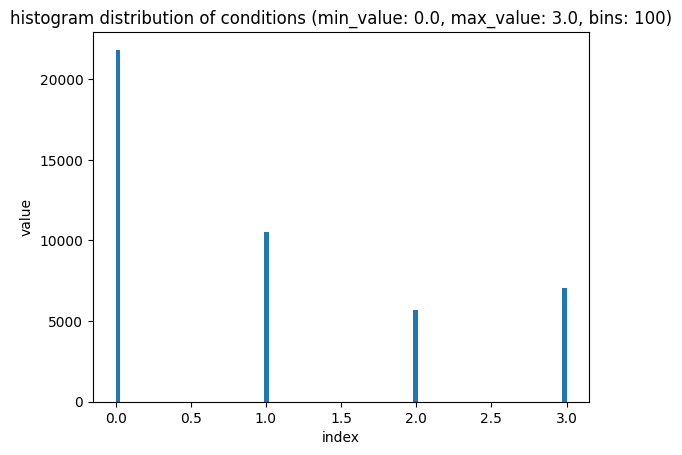

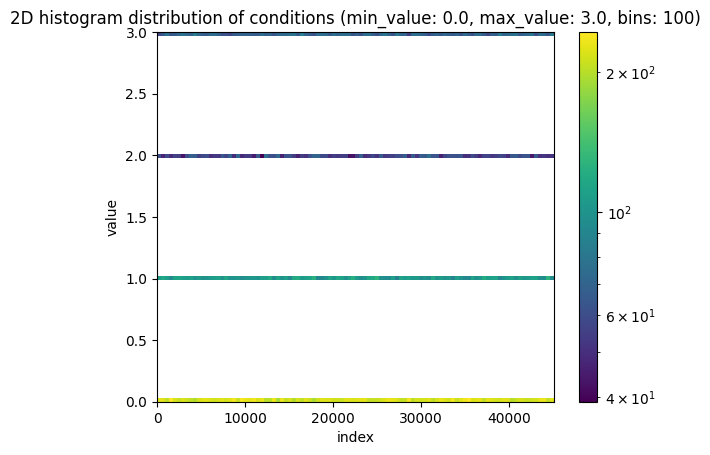

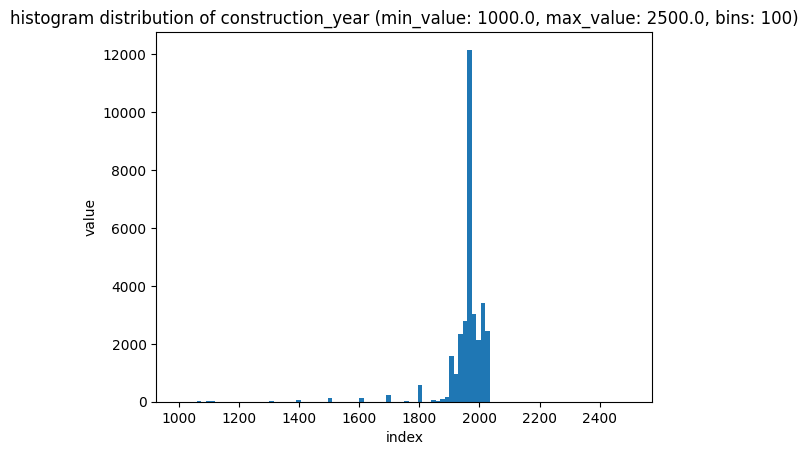

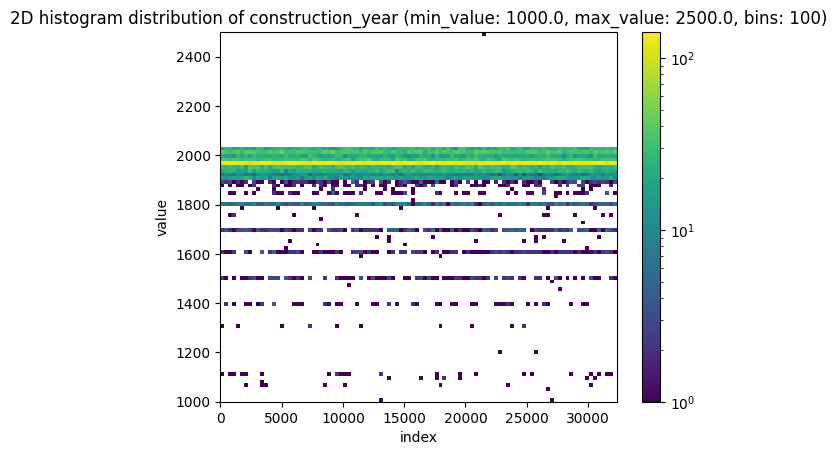

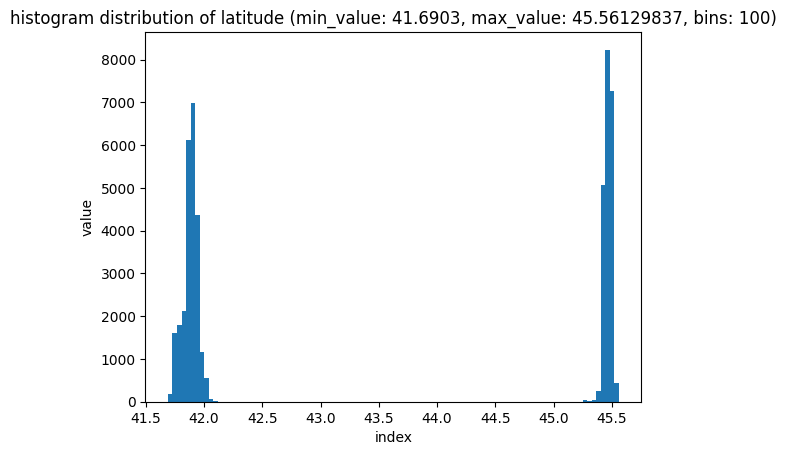

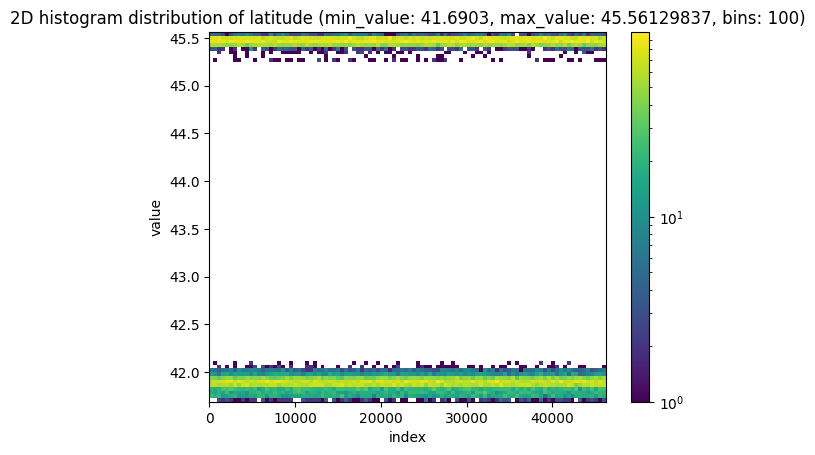

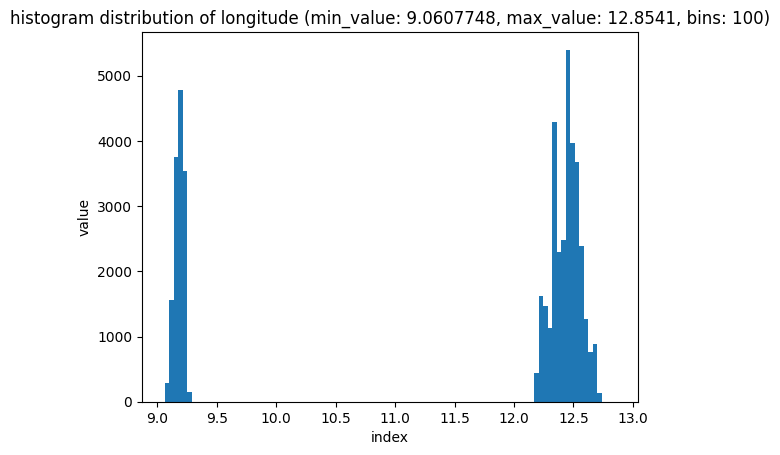

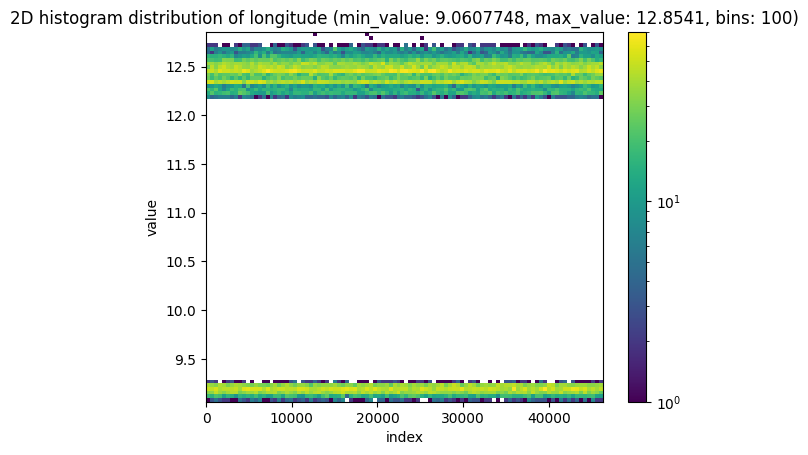

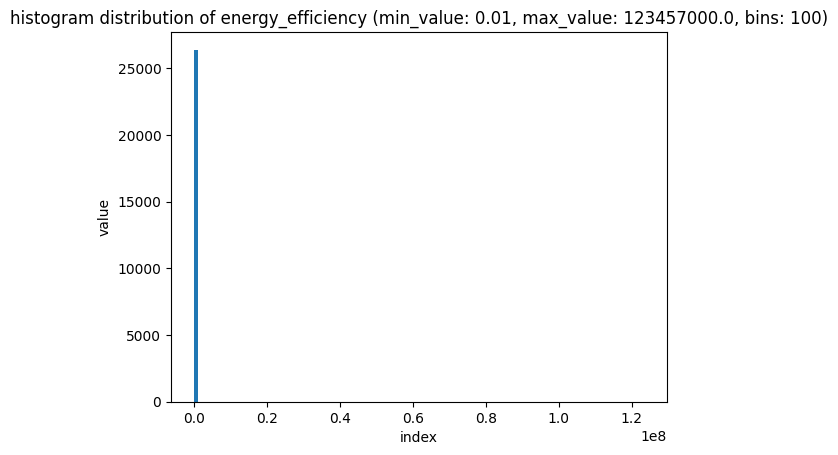

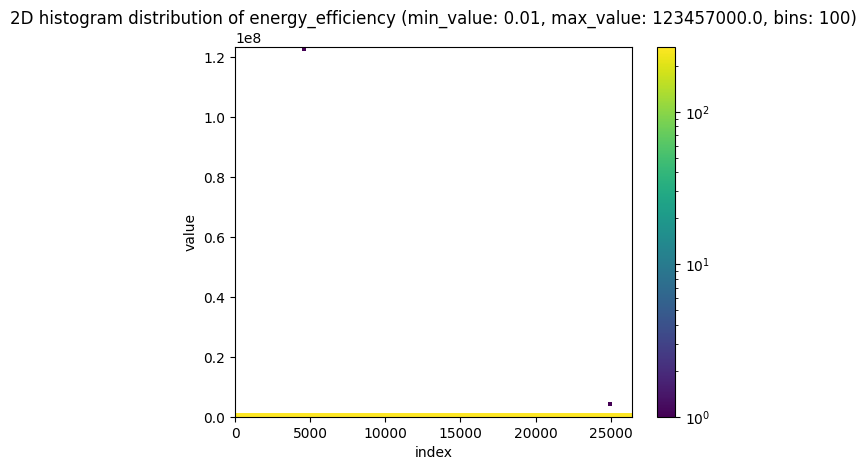

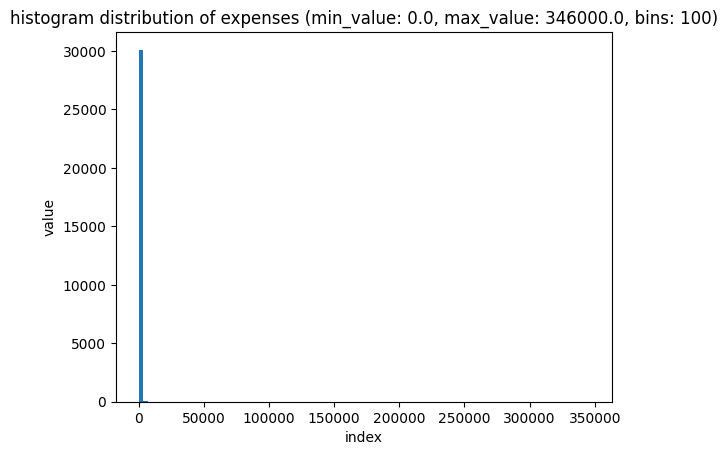

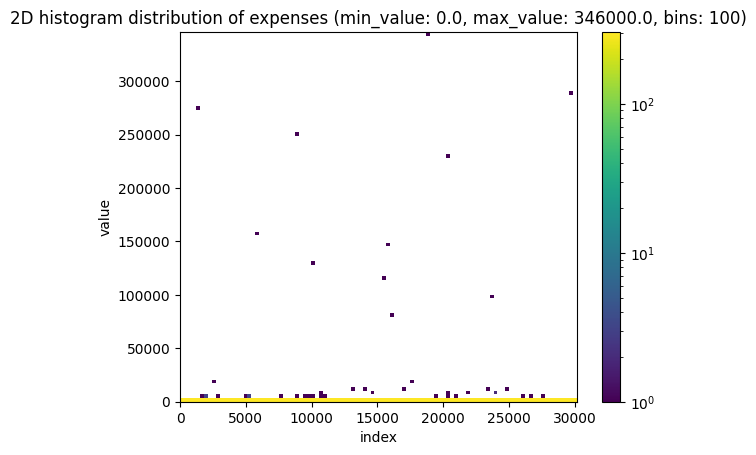

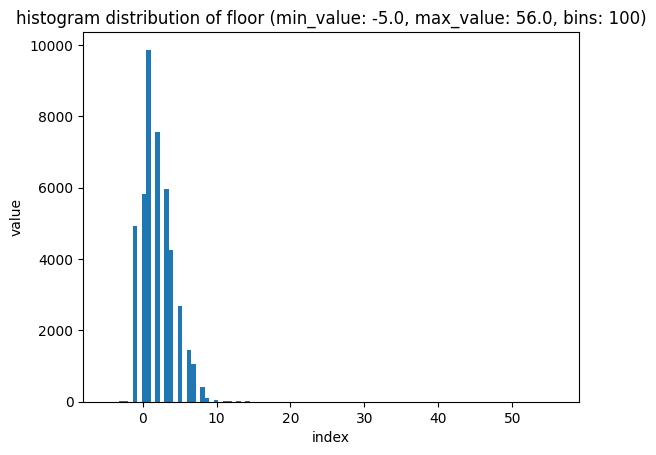

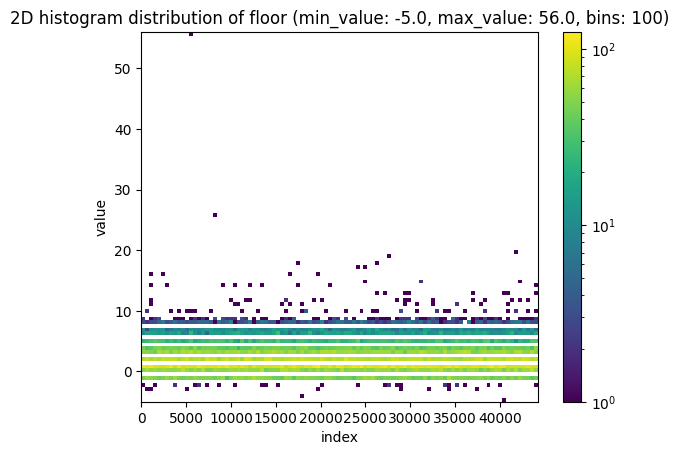

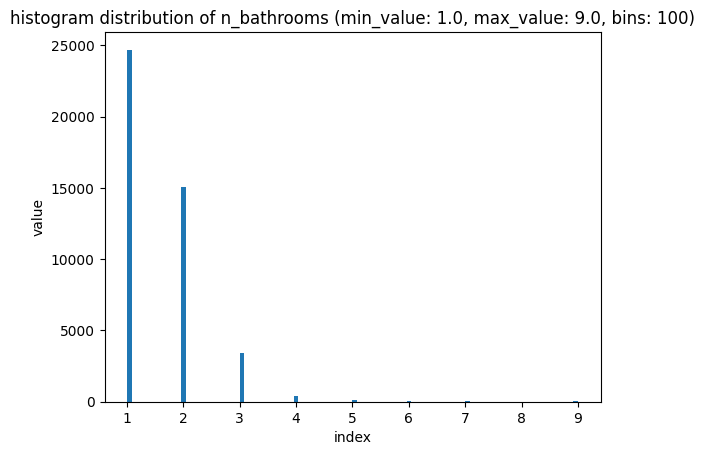

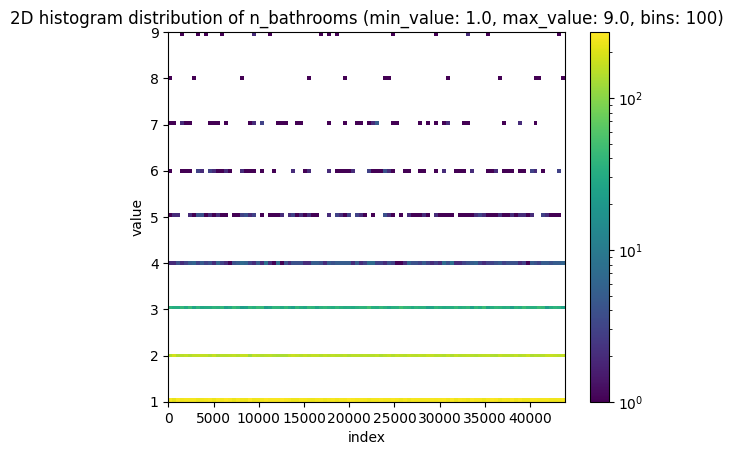

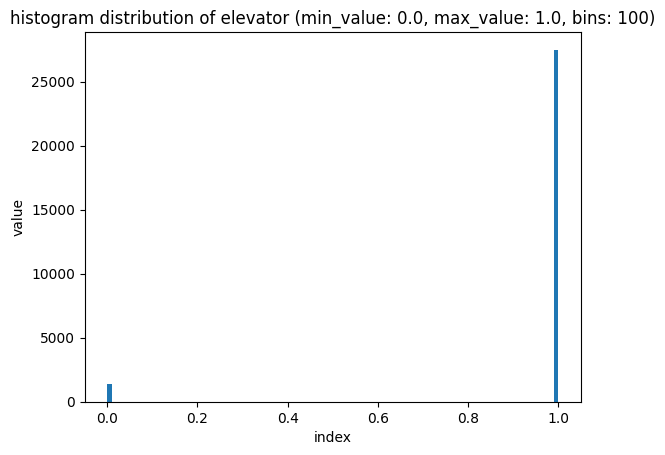

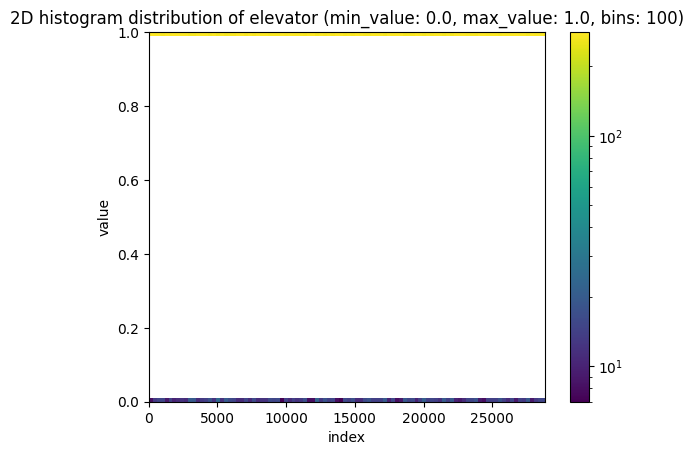

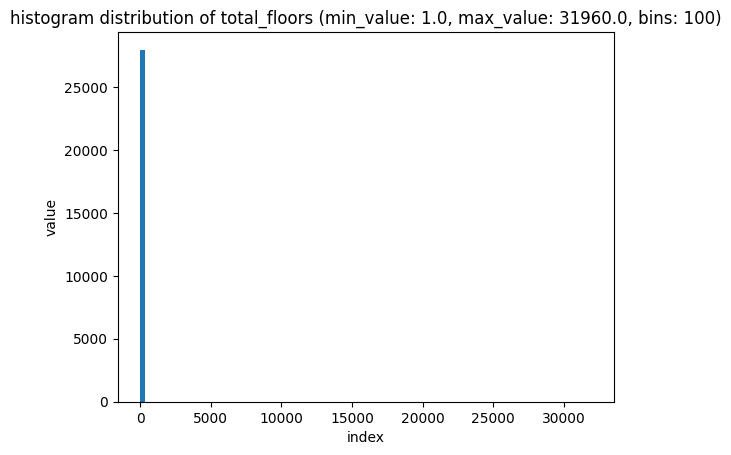

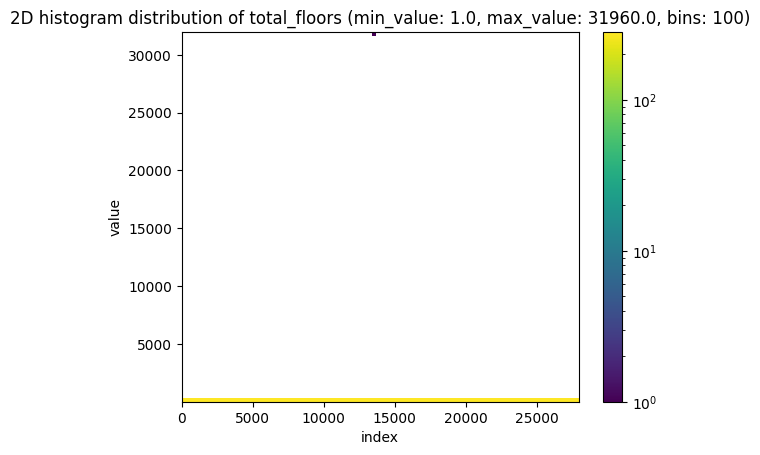

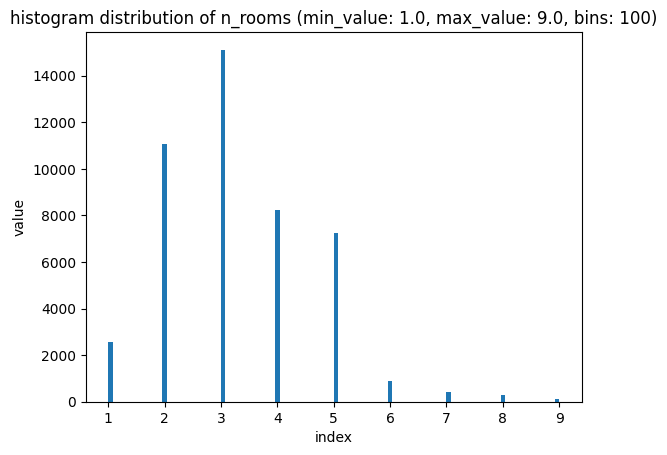

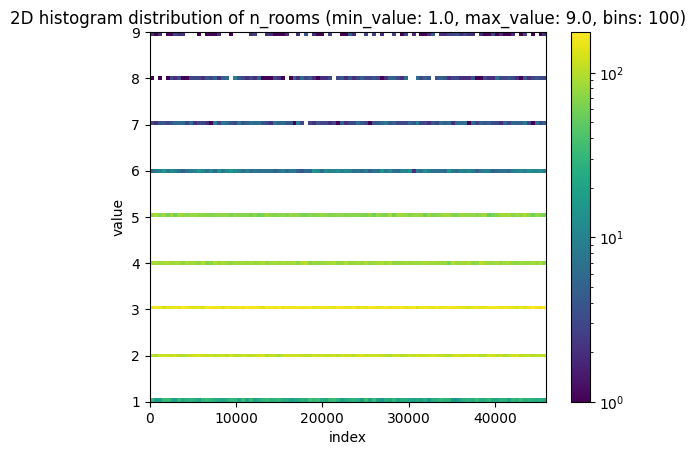

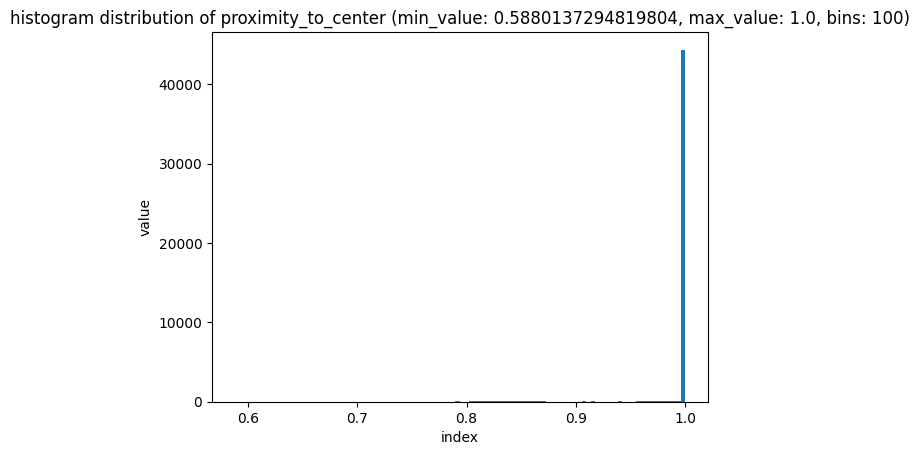

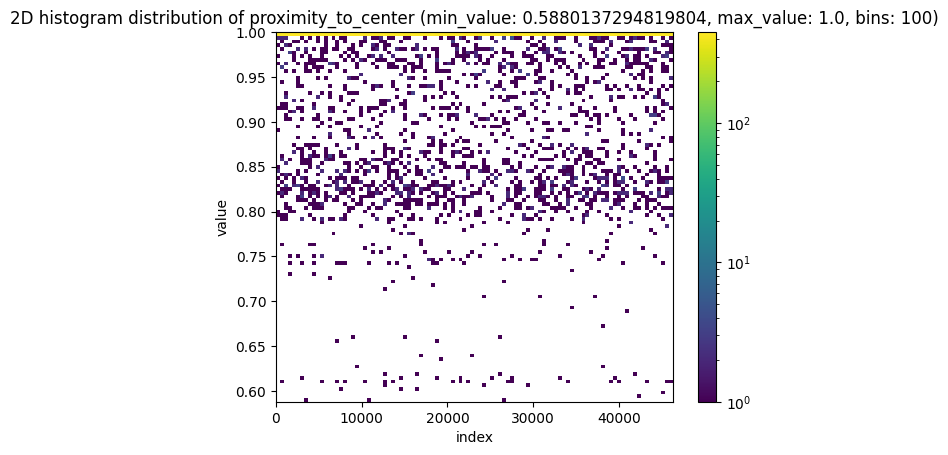

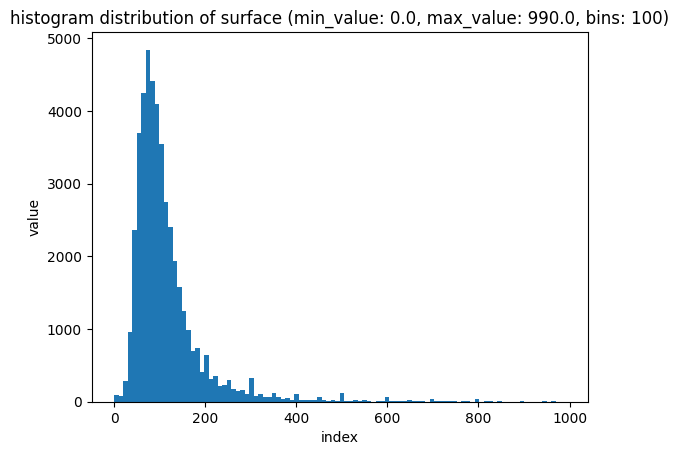

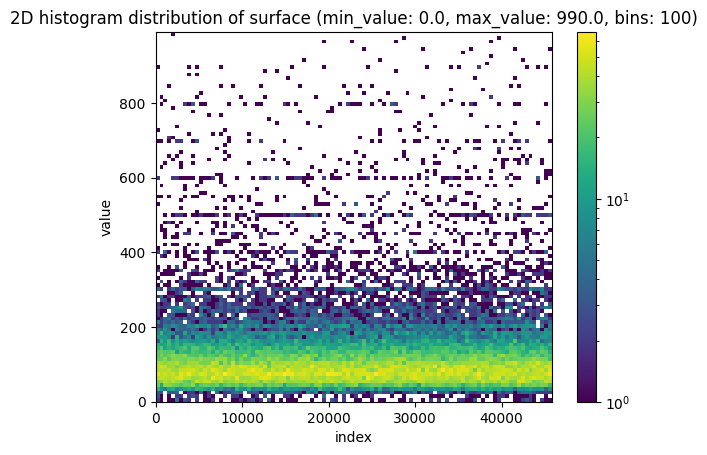

In [27]:
for col in columns_wnan:
    get_hist(train_df, col)

From the graphs we can observe that we have enough information to use the algorithm: imputation of missing values - KNN imputer for all the features which have at least a NaN. 
\
Moving our attention to the KNNImputer, it will fill the NaNs using the mean value from the 5 nearest neighbors of each NaN found in the training set for each feature considered. 

In [28]:
from sklearn.impute import KNNImputer
imputer = KNNImputer()
train_df = pd.DataFrame(imputer.fit_transform(train_df), columns=train_df.columns)

We run again the NaN analysis to verify that there are no more NaNs in any feature. 

In [29]:
analysis1, analysis2 = NaN_analysis(train_df)

In [30]:
analysis1

column  n_nan  percentage
0                 price      0         0.0
1                garden      0         0.0
2               surface      0         0.0
3   proximity_to_center      0         0.0
4               n_rooms      0         0.0
5          total_floors      0         0.0
6              elevator      0         0.0
7           n_bathrooms      0         0.0
8                 floor      0         0.0
9               balcony      0         0.0
10             expenses      0         0.0
11    energy_efficiency      0         0.0
12            longitude      0         0.0
13             latitude      0         0.0
14    construction_year      0         0.0
15           conditions      0         0.0
16                n_poi      0         0.0

In [31]:
analysis2

n_nan  n_rows
0      17       0
1      16       0
2      15       0
3      14       0
4      13       0
5      12       0
6      11       0
7      10       0
8       9       0
9       8       0
10      7       0
11      6       0
12      5       0
13      4       0
14      3       0
15      2       0
16      1       0

In [32]:
train_df

price  balcony  conditions  construction_year   latitude  longitude   
0       60000.0      1.0         0.0             1980.0  41.901300  12.700000  \
1      900000.0      0.0         0.0             1895.0  41.907017  12.481311   
2       33000.0      0.0         0.0             1960.0  41.976500  12.440500   
3      166000.0      0.0         1.0             1994.2  45.484800  12.198200   
4      410000.0      1.0         0.0             1987.8  45.424480  12.328622   
...         ...      ...         ...                ...        ...        ...   
46307  329999.0      1.0         0.0             1929.0  41.923500  12.446100   
46308  599000.0      1.0         2.0             1920.0  41.916743  12.454925   
46309  549000.0      1.0         0.0             1968.6  45.454701   9.242711   
46310  189000.0      1.0         0.0             1965.0  45.445605   9.245942   
46311  355000.0      1.0         1.0             1970.0  41.877000  12.431400   

       energy_efficiency  expenses  floor  garden  n_bathrooms  elevator   
0                175.000      30.0    2.0     0.0          1.0       1.0  \
1                117.266     136.0    3.0     0.0          1.0       1.0   
2                204.200      30.0    4.0     0.0          1.0       0.8   
3                175.000      34.6    1.0     1.0          1.0       1.0   
4                 65.910     127.6    3.0     0.0          2.0       1.0   
...                  ...       ...    ...     ...          ...       ...   
46307            175.000      35.0    3.0     0.0          1.0       0.8   
46308            141.102     170.0    6.0     0.0          2.0       1.0   
46309            107.204     166.4    5.0     0.0          2.0       1.0   
46310            182.776     150.0   -1.0     1.0          1.0       1.0   
46311            175.000     100.0    1.0     0.0          1.0       1.0   

       total_floors  n_rooms  proximity_to_center  surface  n_poi  
0               3.0      1.0              1.00000     35.0    0.0  
1               5.2      3.0              1.00000    131.0  191.0  
2               4.0      1.0              1.00000     16.0    0.0  
3               1.0      2.0              0.99205    100.0    0.0  
4               5.0      3.0              1.00000     90.0  105.0  
...             ...      ...                  ...      ...    ...  
46307           4.0      3.0              1.00000     88.0   83.0  
46308           5.6      5.0              1.00000    189.0  247.0  
46309           6.4      3.0              1.00000    140.0  243.0  
46310           4.8      3.0              1.00000     70.0  223.0  
46311           5.0      4.0              1.00000    101.0   20.0  

[46312 rows x 17 columns]

We can notice that some NaN have been filled , by the KNN Imputer, with values which do not respect reality, for example we have that an house has 0.8 as elevator (which is neither 0 = no elevator nor 1 = yes elevator). Actually this is not a problem for the model, these data are valid for the mathematical model we are building.  

# 2. Dataset analysis

- plot the features
- remove the outliers (only on the train set) 


We plot again the histograms also in 2D as before for every feature, with the only difference that now we have assigned values to the NaNs. 

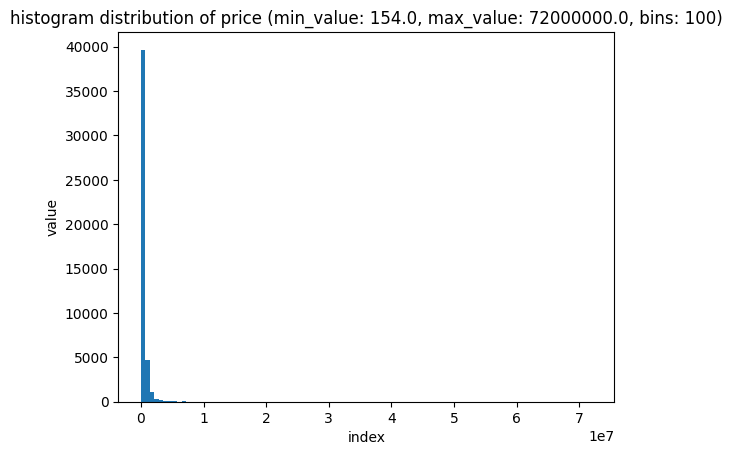

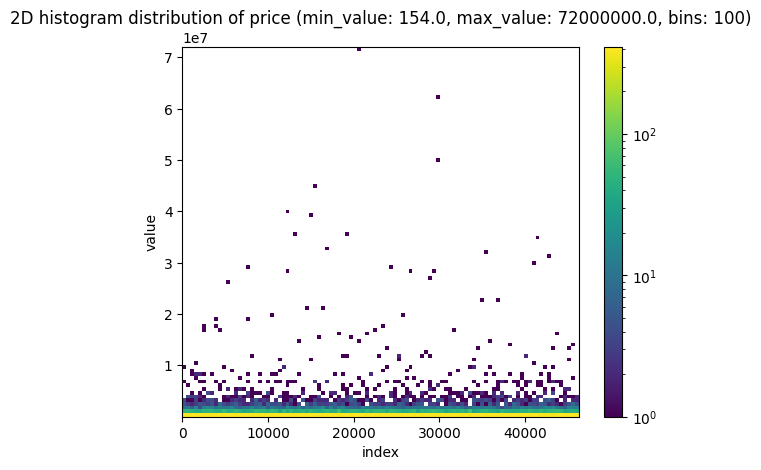

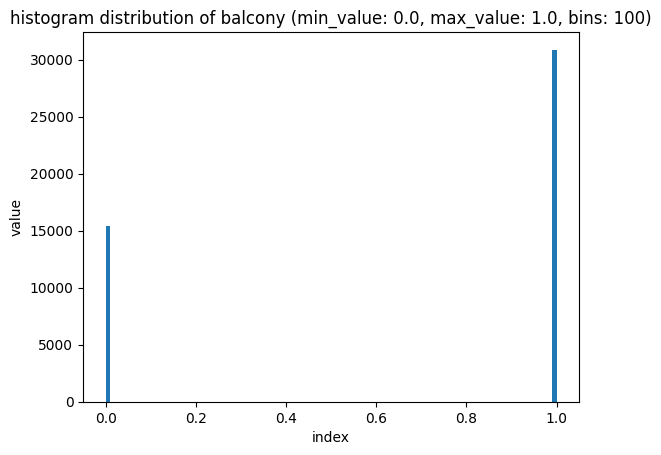

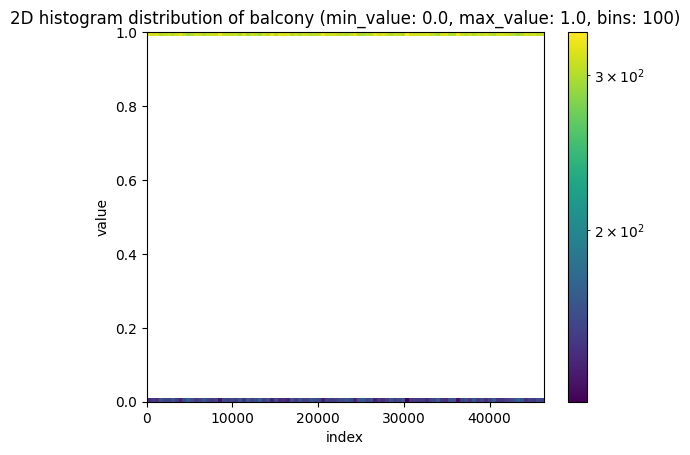

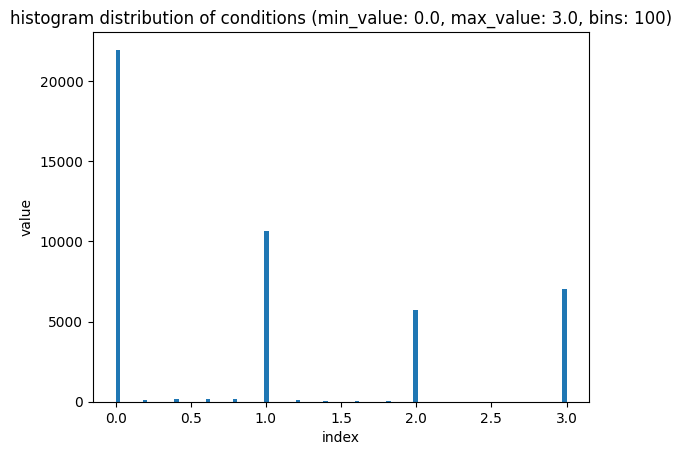

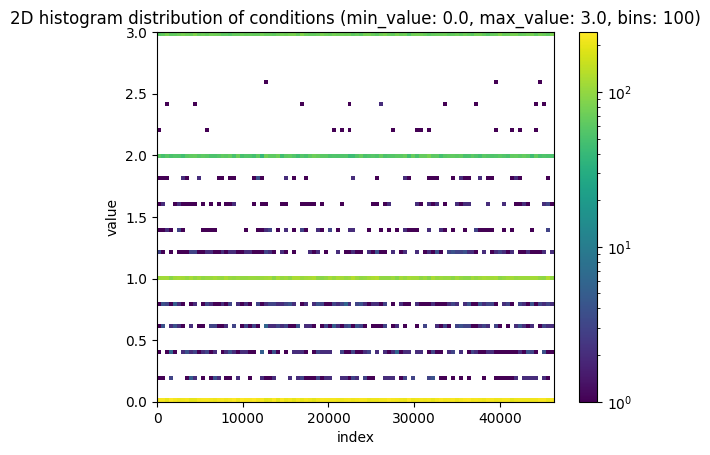

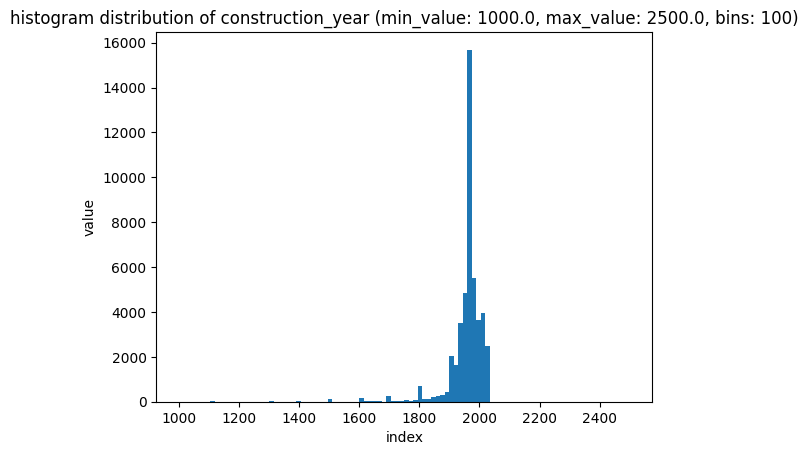

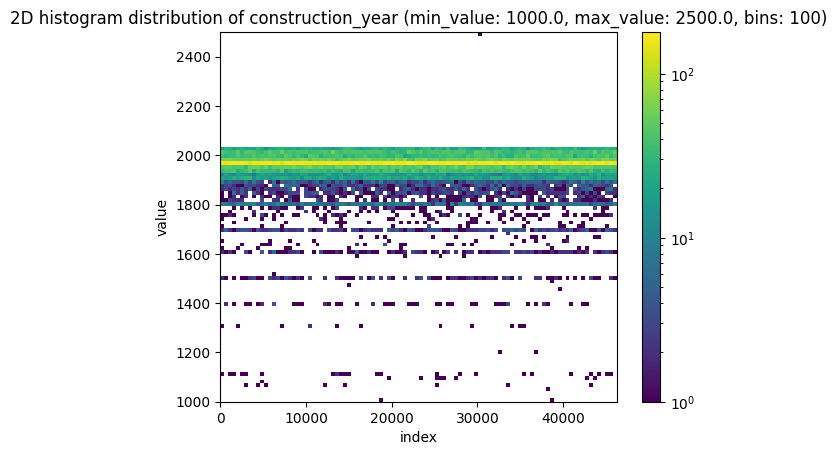

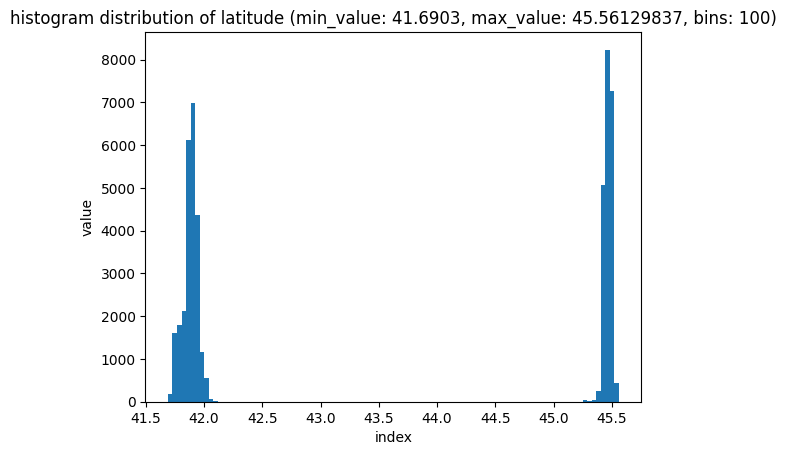

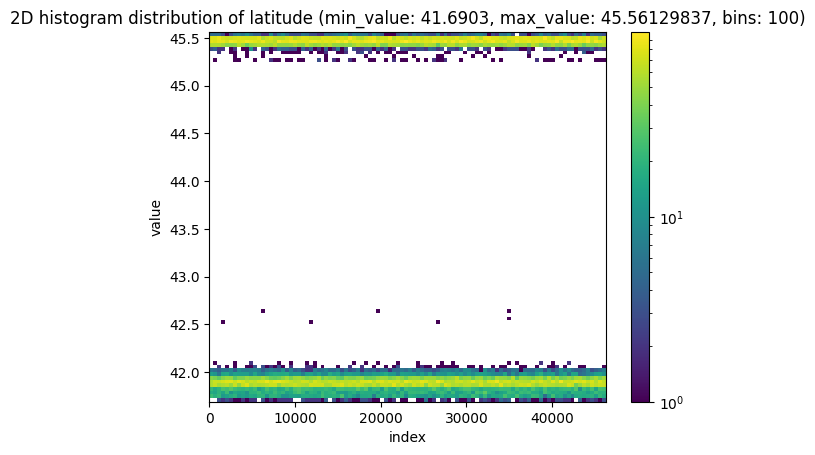

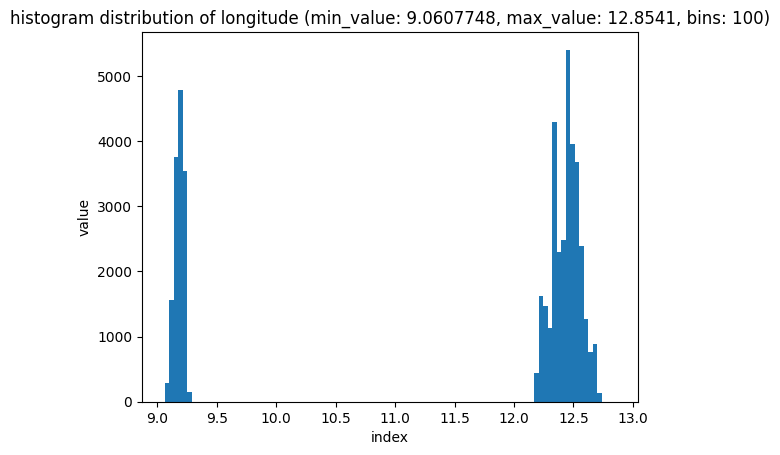

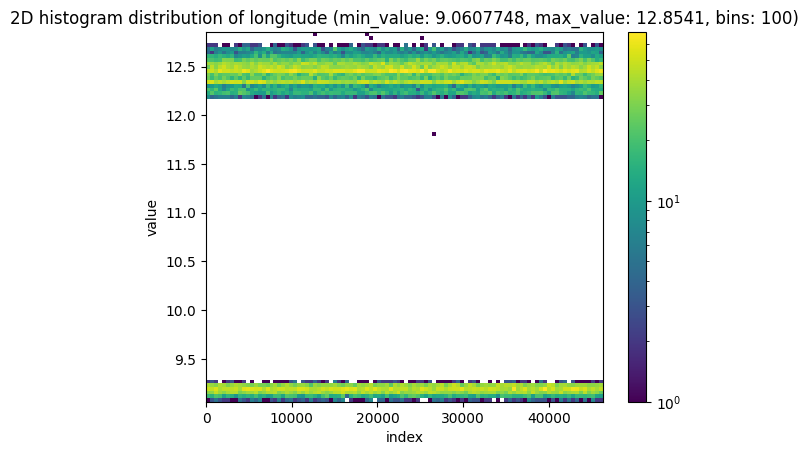

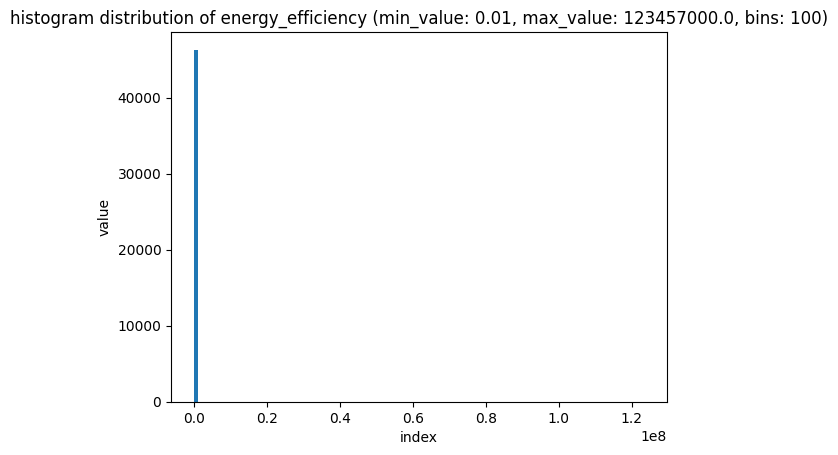

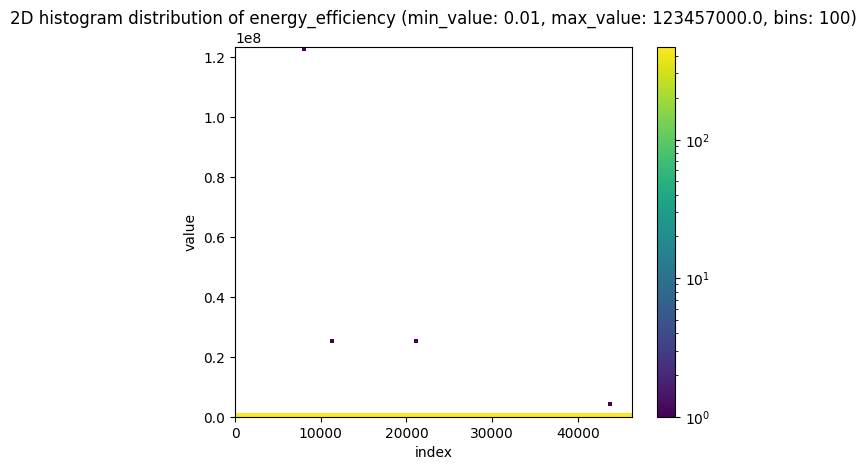

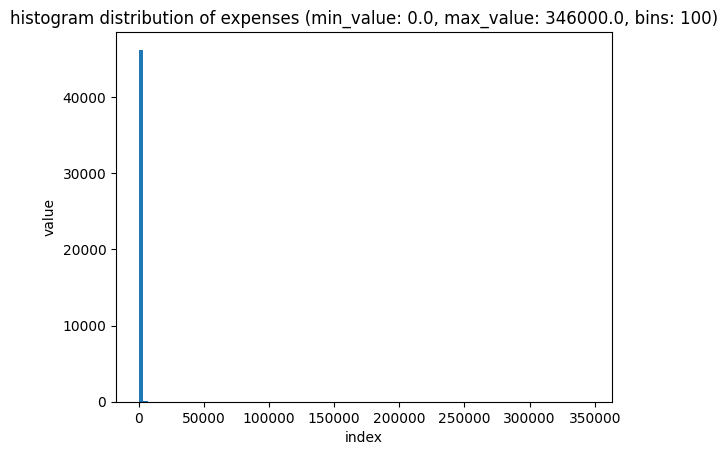

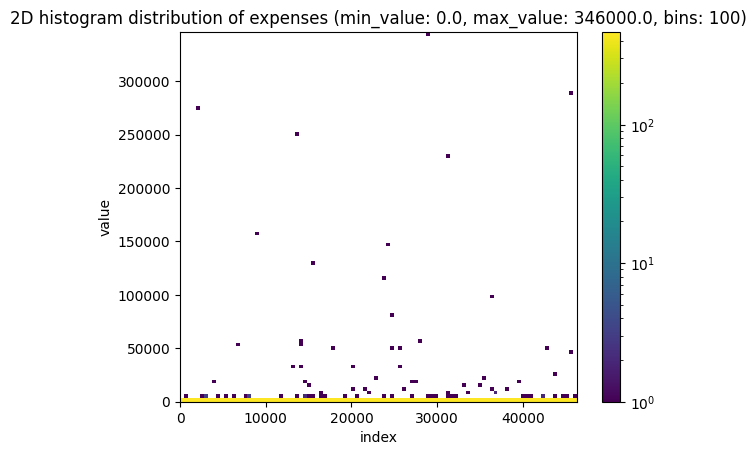

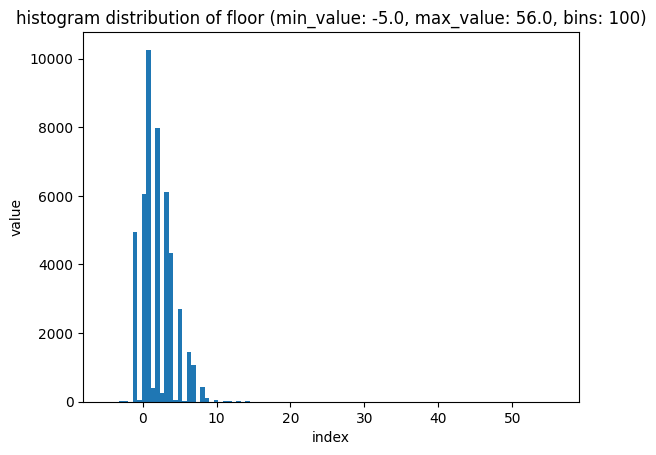

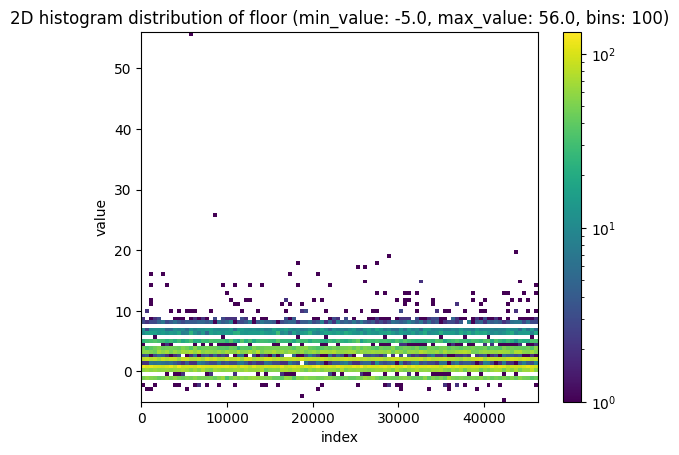

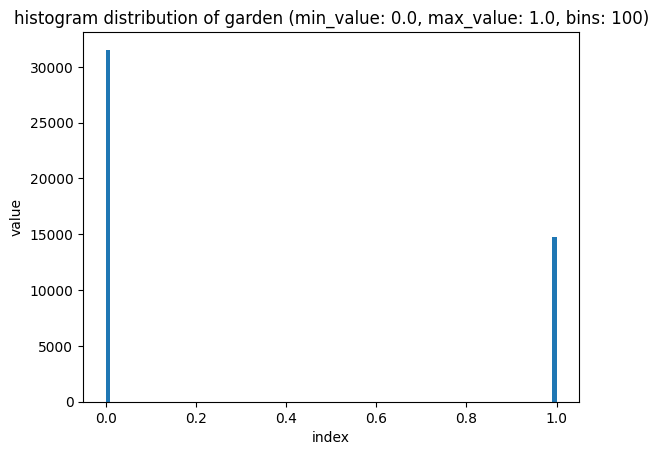

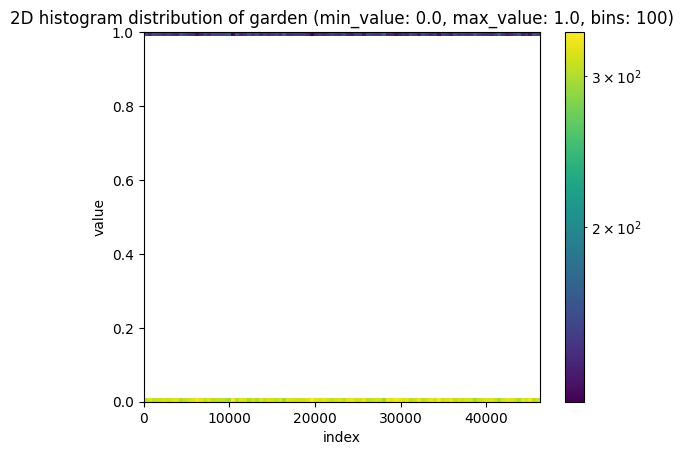

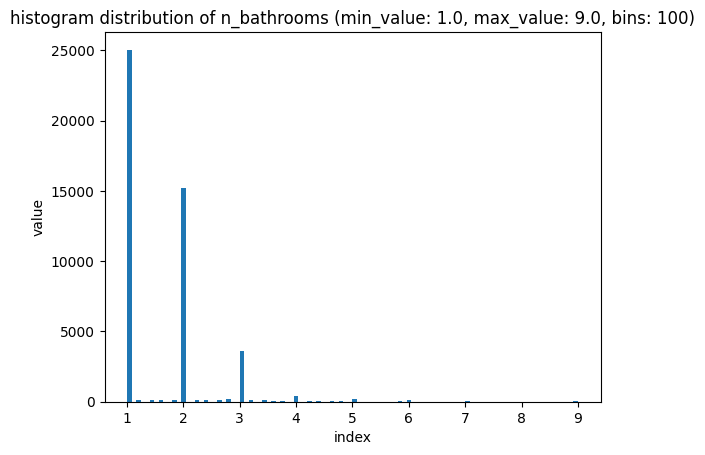

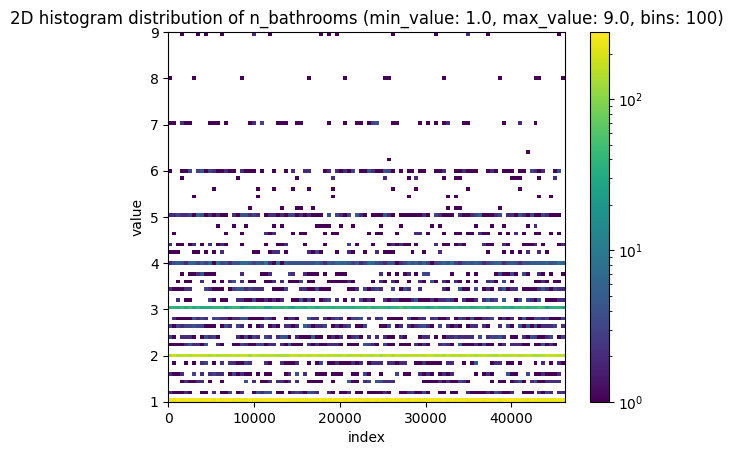

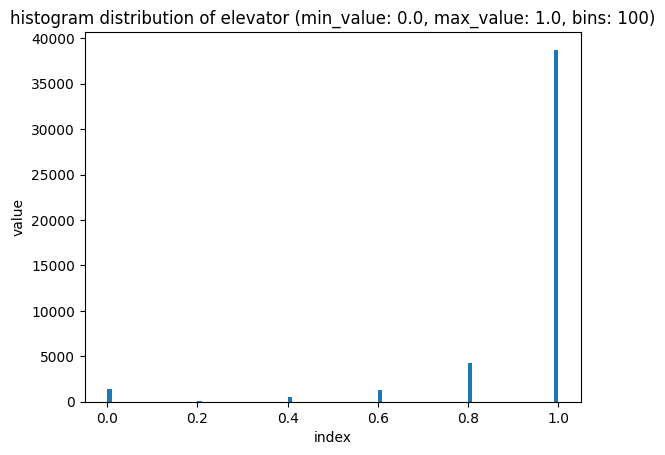

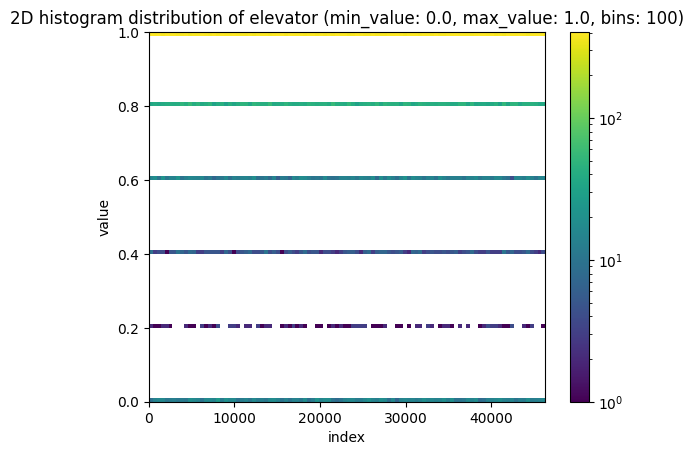

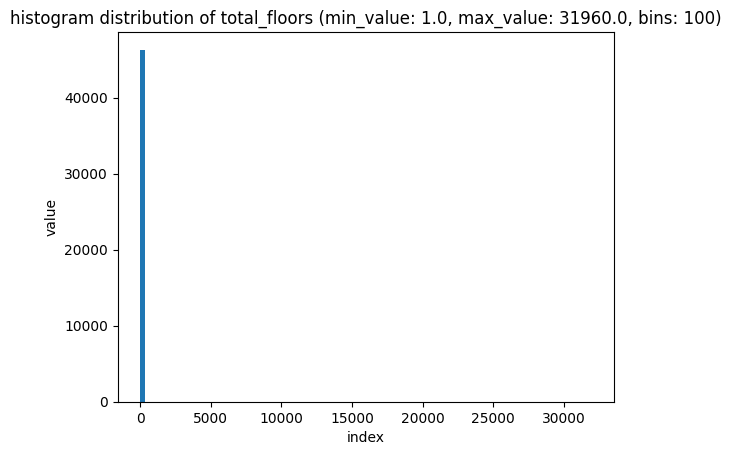

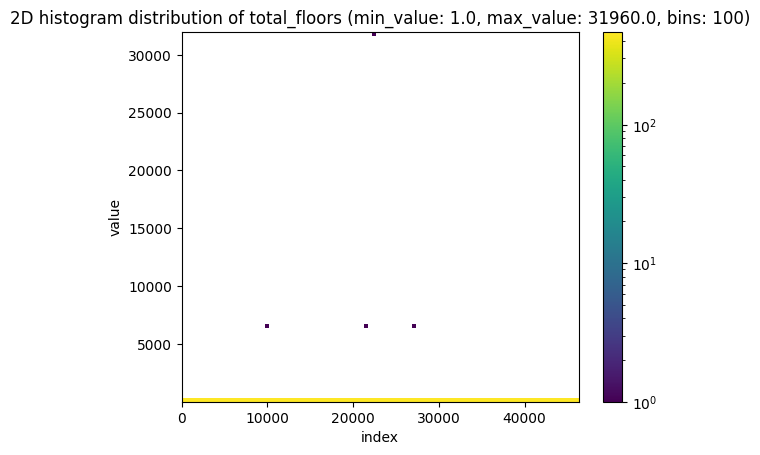

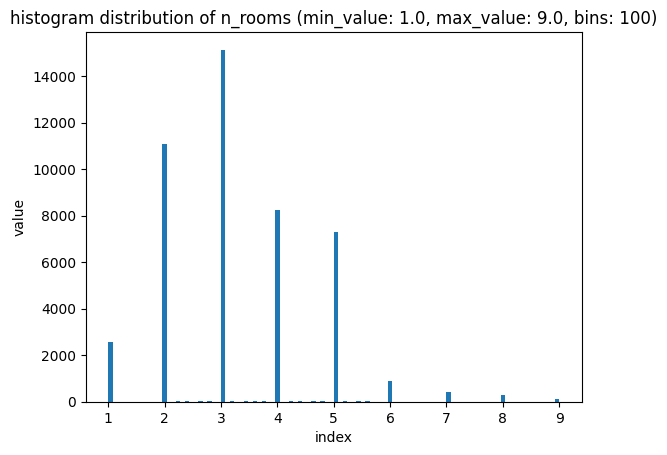

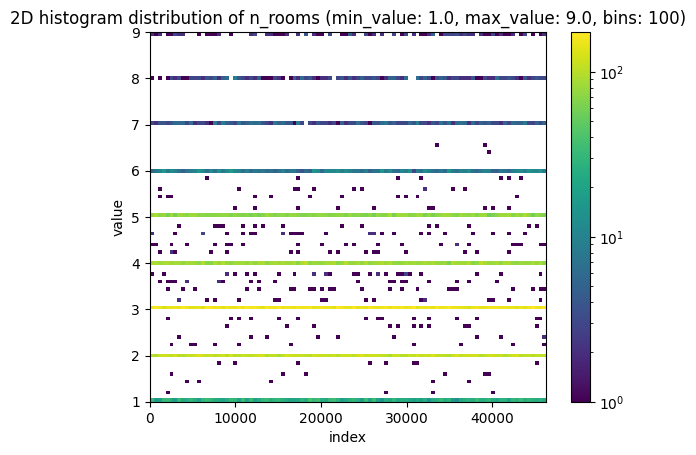

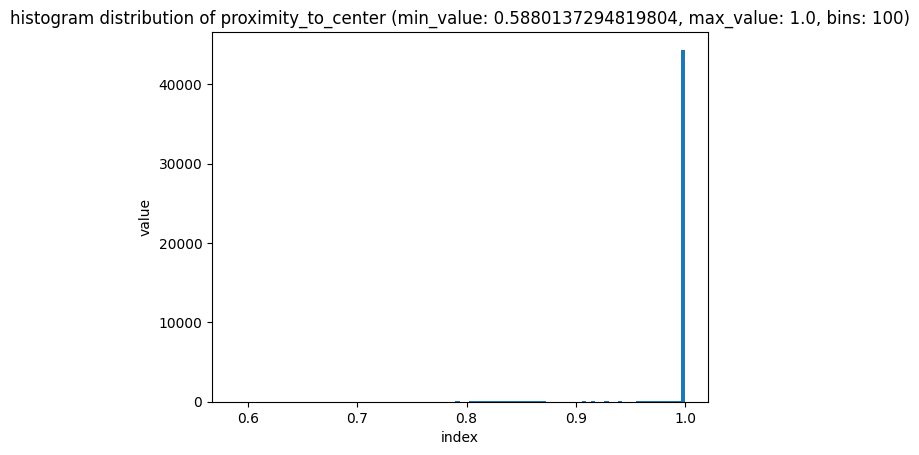

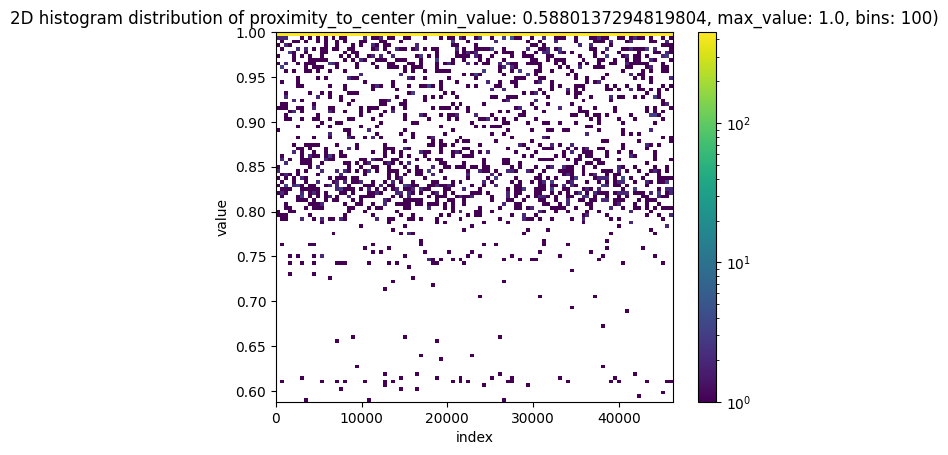

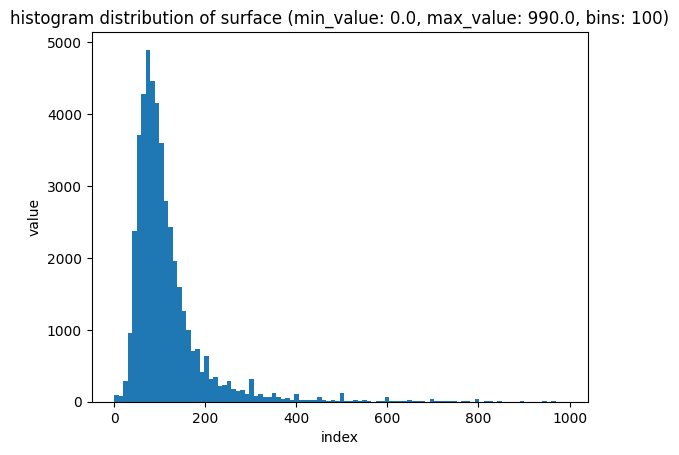

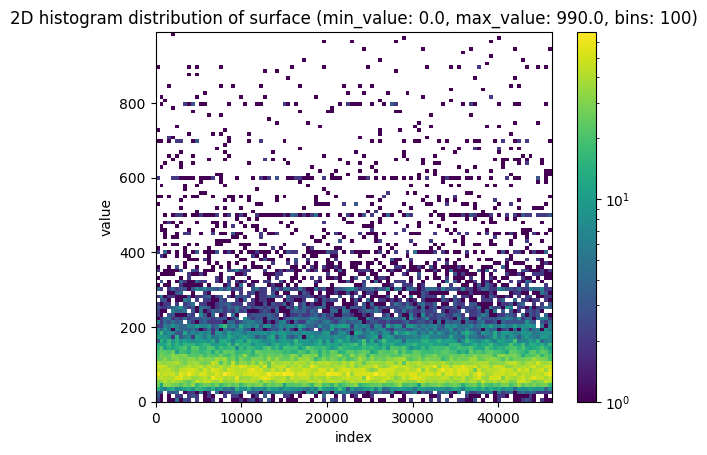

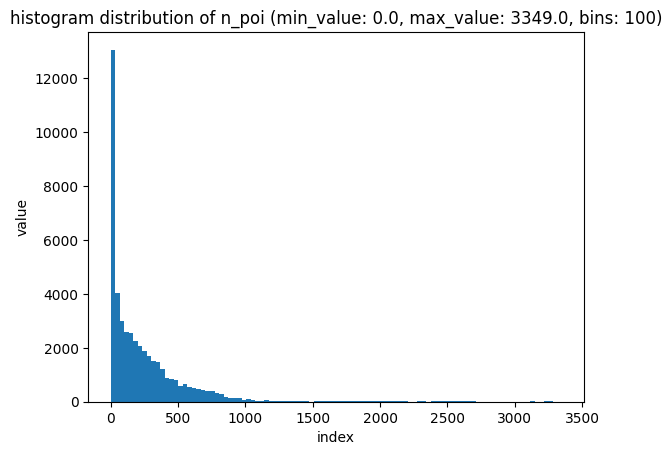

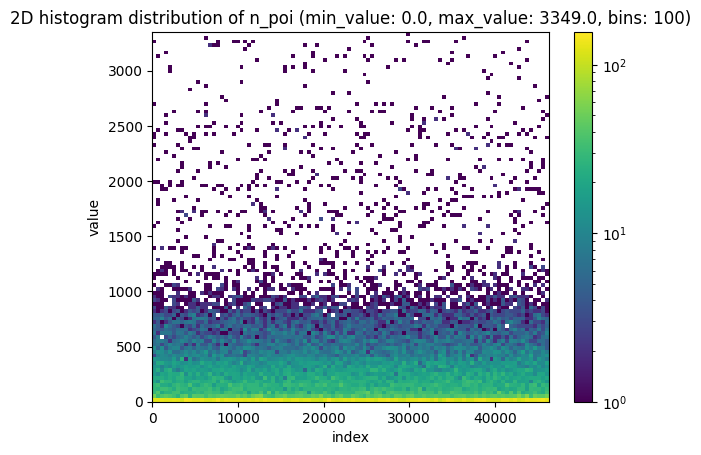

In [33]:
for col in train_df.columns:
    get_hist(train_df, col)

In [34]:
train_df

price  balcony  conditions  construction_year   latitude  longitude   
0       60000.0      1.0         0.0             1980.0  41.901300  12.700000  \
1      900000.0      0.0         0.0             1895.0  41.907017  12.481311   
2       33000.0      0.0         0.0             1960.0  41.976500  12.440500   
3      166000.0      0.0         1.0             1994.2  45.484800  12.198200   
4      410000.0      1.0         0.0             1987.8  45.424480  12.328622   
...         ...      ...         ...                ...        ...        ...   
46307  329999.0      1.0         0.0             1929.0  41.923500  12.446100   
46308  599000.0      1.0         2.0             1920.0  41.916743  12.454925   
46309  549000.0      1.0         0.0             1968.6  45.454701   9.242711   
46310  189000.0      1.0         0.0             1965.0  45.445605   9.245942   
46311  355000.0      1.0         1.0             1970.0  41.877000  12.431400   

       energy_efficiency  expenses  floor  garden  n_bathrooms  elevator   
0                175.000      30.0    2.0     0.0          1.0       1.0  \
1                117.266     136.0    3.0     0.0          1.0       1.0   
2                204.200      30.0    4.0     0.0          1.0       0.8   
3                175.000      34.6    1.0     1.0          1.0       1.0   
4                 65.910     127.6    3.0     0.0          2.0       1.0   
...                  ...       ...    ...     ...          ...       ...   
46307            175.000      35.0    3.0     0.0          1.0       0.8   
46308            141.102     170.0    6.0     0.0          2.0       1.0   
46309            107.204     166.4    5.0     0.0          2.0       1.0   
46310            182.776     150.0   -1.0     1.0          1.0       1.0   
46311            175.000     100.0    1.0     0.0          1.0       1.0   

       total_floors  n_rooms  proximity_to_center  surface  n_poi  
0               3.0      1.0              1.00000     35.0    0.0  
1               5.2      3.0              1.00000    131.0  191.0  
2               4.0      1.0              1.00000     16.0    0.0  
3               1.0      2.0              0.99205    100.0    0.0  
4               5.0      3.0              1.00000     90.0  105.0  
...             ...      ...                  ...      ...    ...  
46307           4.0      3.0              1.00000     88.0   83.0  
46308           5.6      5.0              1.00000    189.0  247.0  
46309           6.4      3.0              1.00000    140.0  243.0  
46310           4.8      3.0              1.00000     70.0  223.0  
46311           5.0      4.0              1.00000    101.0   20.0  

[46312 rows x 17 columns]

From the graphs we can observe that there are no outliers for the features: id, balcony, garden, conditions, latitude, longitude, n_rooms and elevator. 
\
We do a boxplot only for the features with the outliers, in order to then remove the outliers. 

In [35]:
def boxplot(df, feature):
    plt.boxplot(df.loc[:, feature])
    plt.title('boxplot of {}'.format(feature))
    plt.ylabel('value')
    plt.show()
    plt.close()
    return

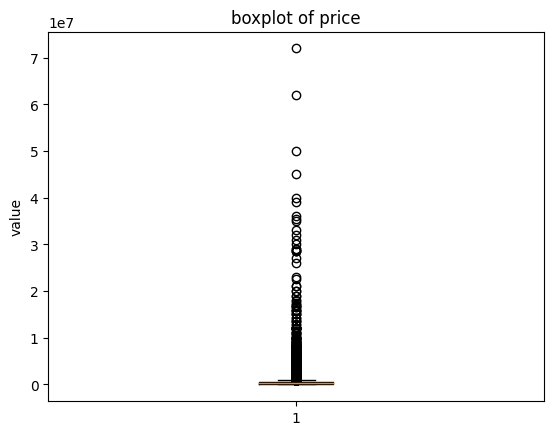

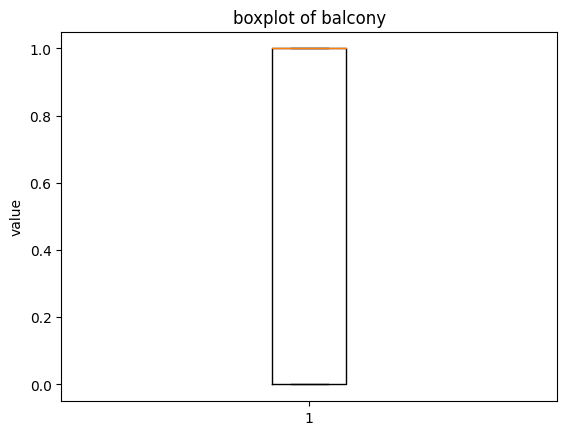

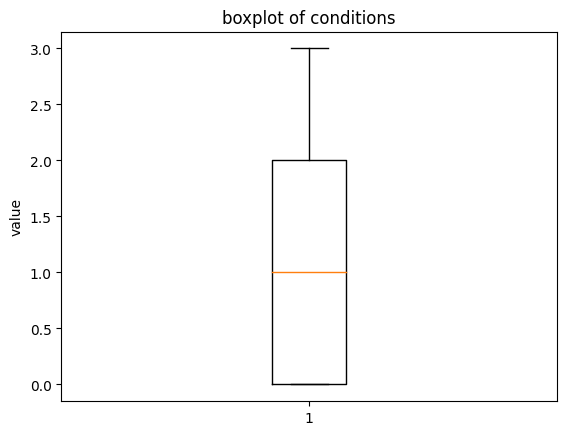

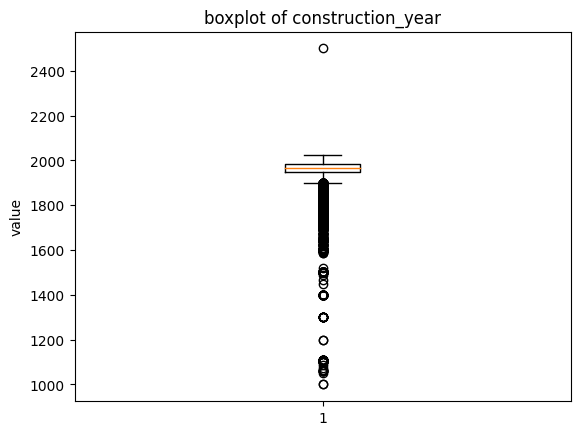

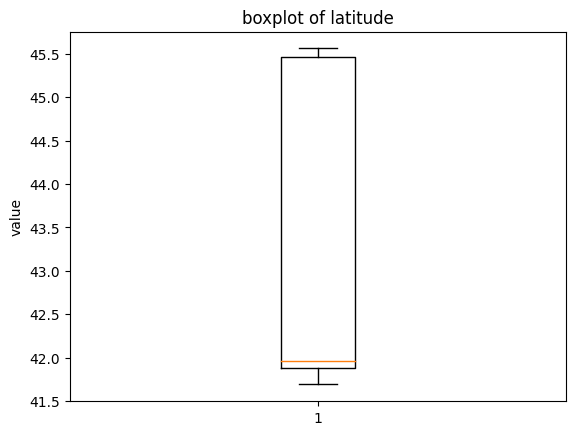

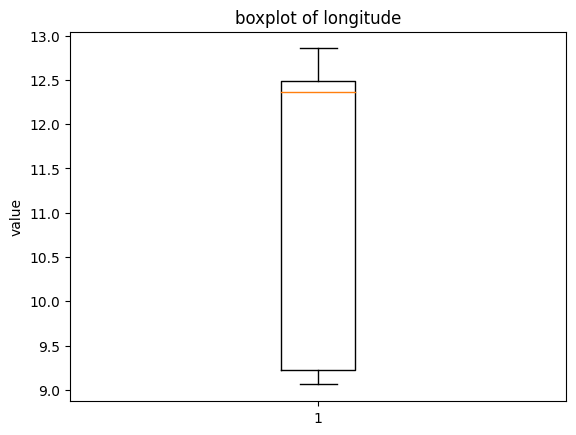

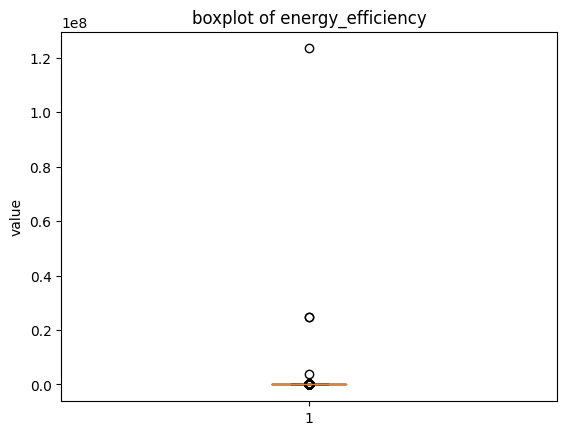

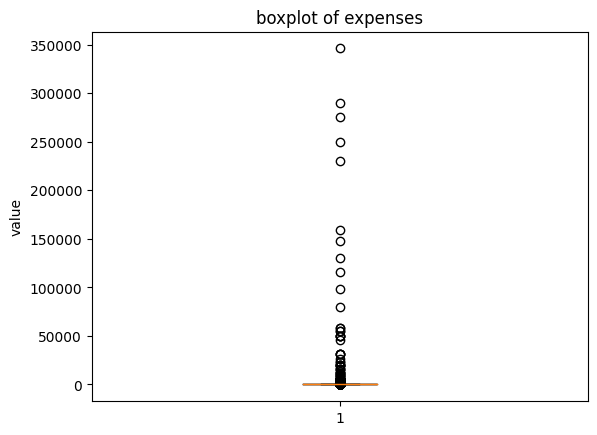

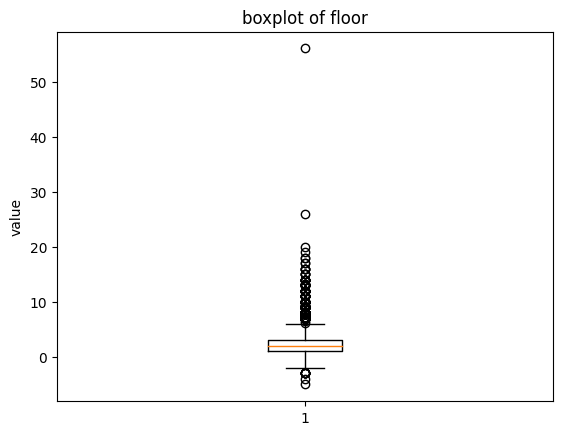

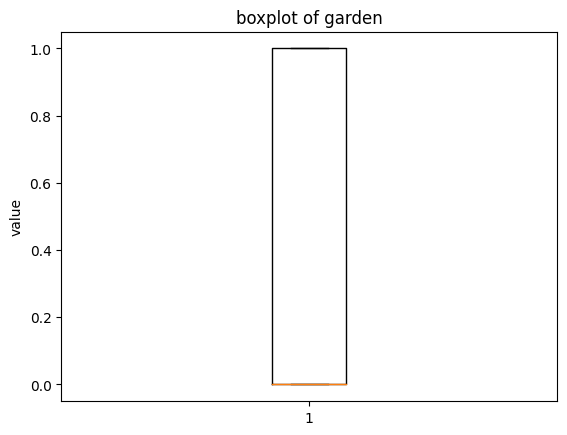

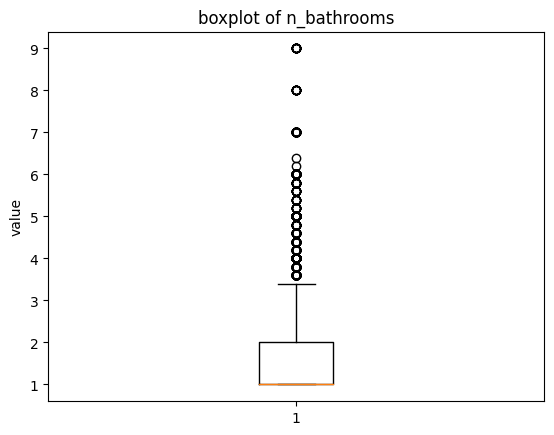

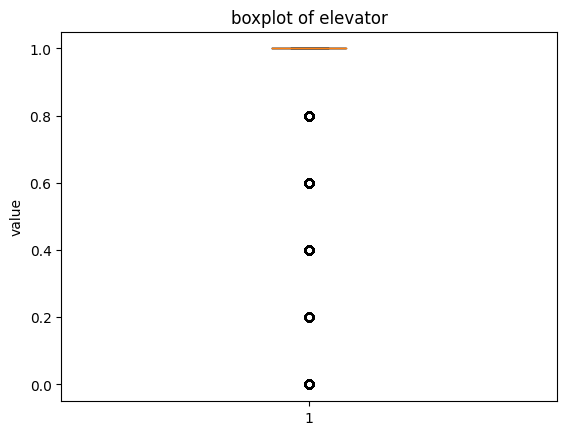

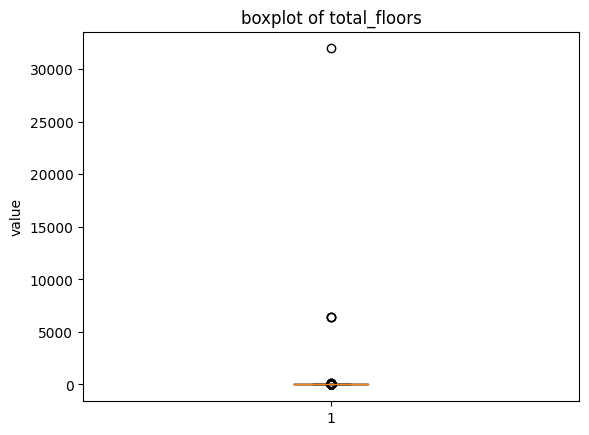

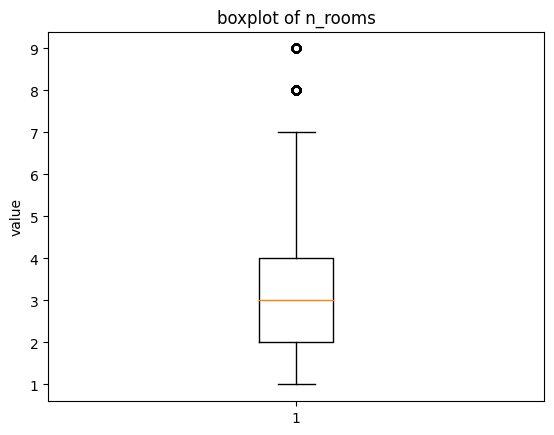

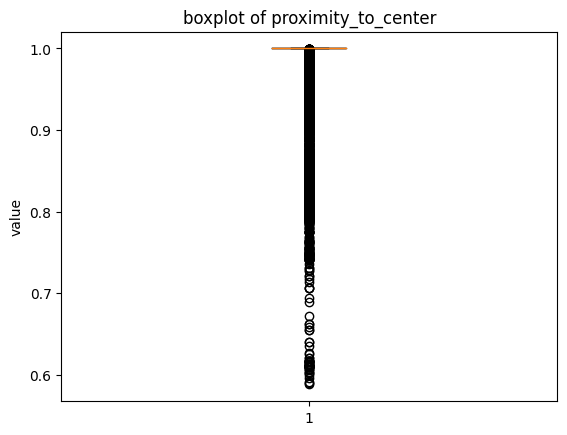

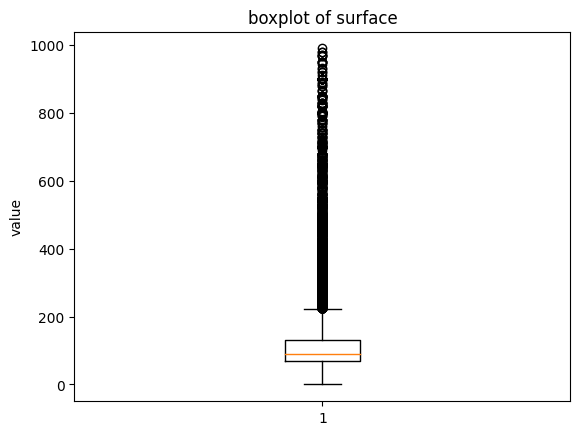

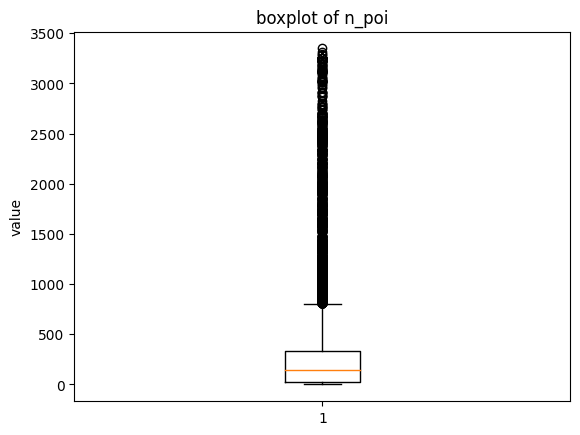

In [36]:
for col in train_df.columns:
    boxplot(train_df, col)

In [37]:
# minmax scaler
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
train_df = pd.DataFrame(scaler.fit_transform(train_df), columns=train_df.columns)
# normalization
from sklearn.preprocessing import Normalizer
normalizer = Normalizer()
train_df = pd.DataFrame(normalizer.fit_transform(train_df), columns=train_df.columns)

We remove the outliers with the z score.  

In [38]:
original_shape = train_df.shape[0]
z_scores = zscore(train_df)
abs_z_scores = np.abs(z_scores)
filtered_entries = (abs_z_scores < 4.5).all(axis=1)

In [39]:
train_df = train_df[filtered_entries]
new_shape = train_df.shape[0]

In [40]:
print('original shape: {}'.format(original_shape))
print('new shape: {}'.format(new_shape))
print('percentage of rows removed: {}%'.format(((original_shape-new_shape)*100)/original_shape))

original shape: 46312
new shape: 44824
percentage of rows removed: 3.2129901537398515%


In [41]:
# ricalcolo lo zscore sulla singola feature e seleziono il sottoinsieme di entry che hanno zscore < 5 (tmp_df)
# quindi calcolo il minimo e il massimo di tmp_df sulla feature che sto considerando per poi 
# sostituire i valori di train_df che hanno zscore > 5, sulla feature che sto considerando, con il minimo o il massimo
'''
for col in train_df.columns:
    z_scores = zscore(train_df[col])
    abs_z_scores = np.abs(z_scores)
    filtered_entries = (abs_z_scores < 5)
    tmp_df = train_df[col][filtered_entries]
    lower, upper = tmp_df.min(), tmp_df.max()
    train_df[col] = train_df[col].apply(lambda x: lower if x < lower else upper if x > upper else x)
'''
pass

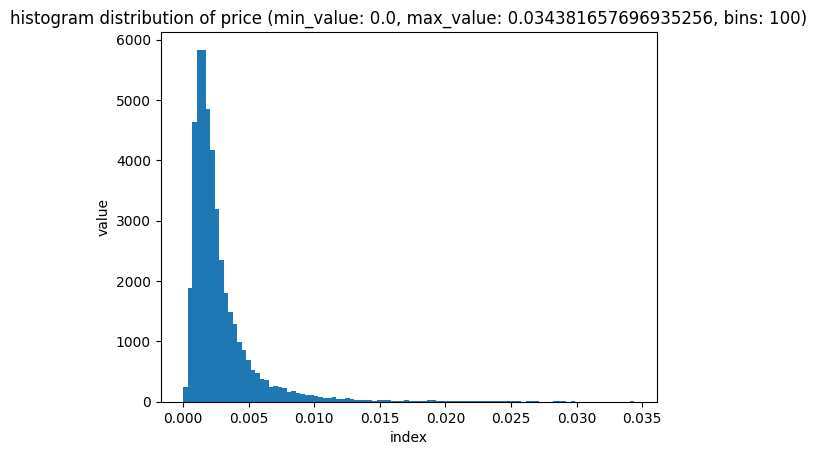

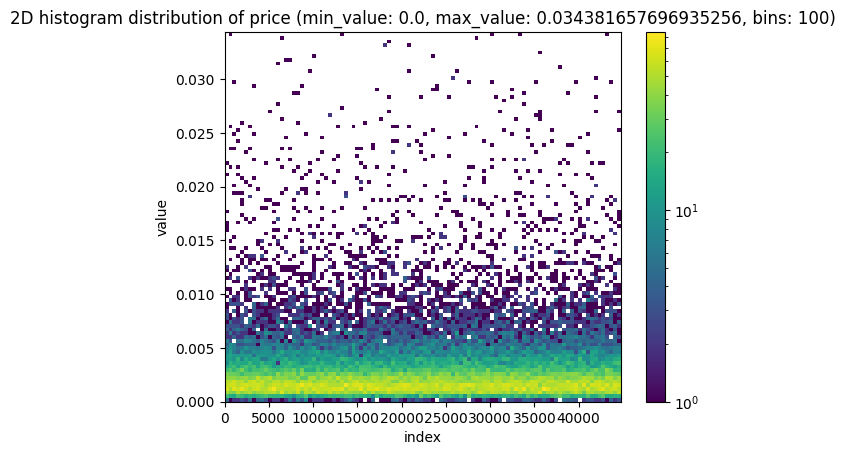

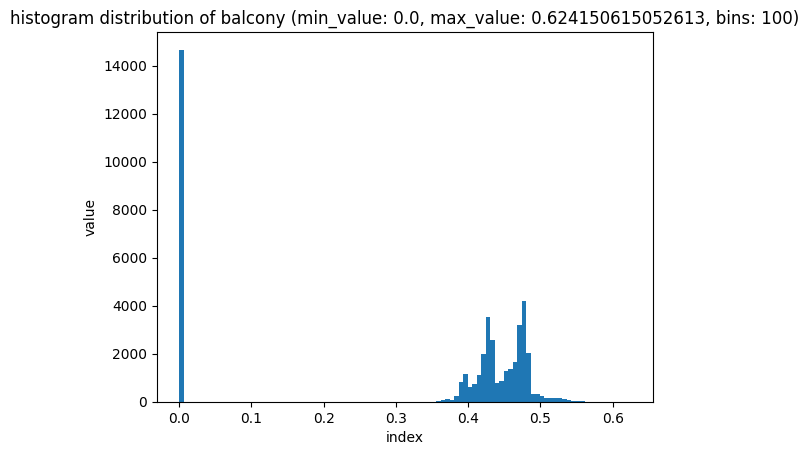

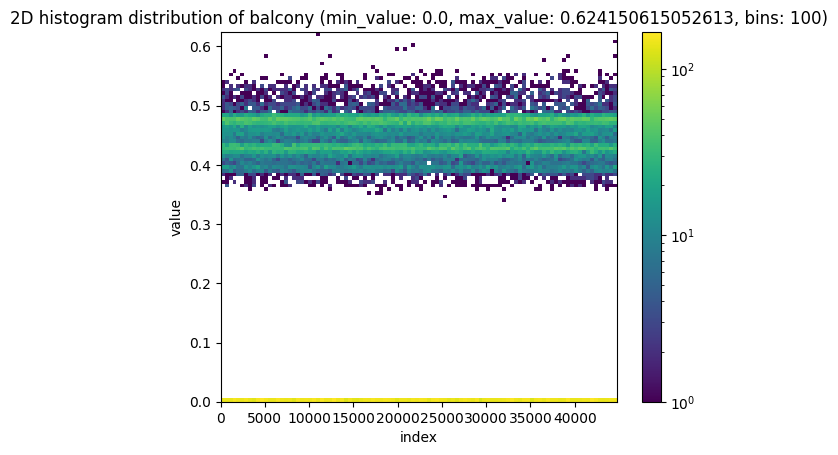

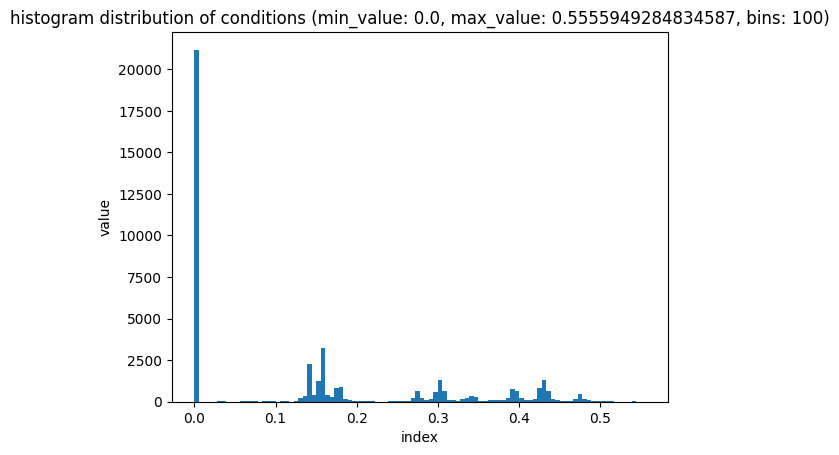

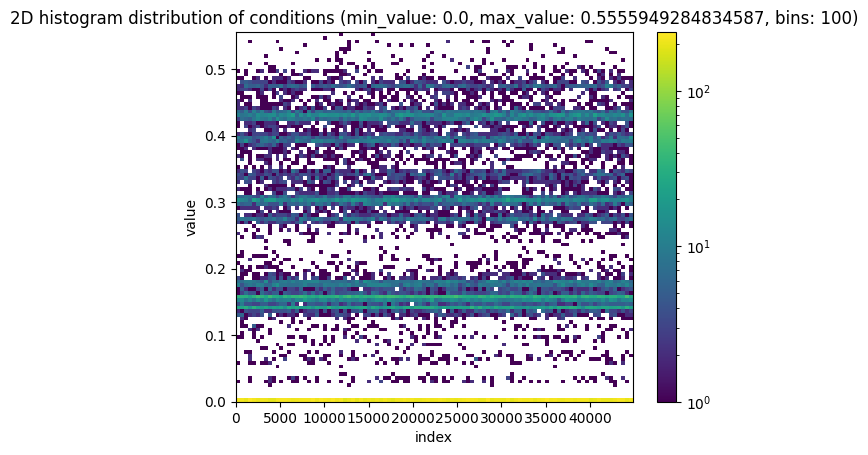

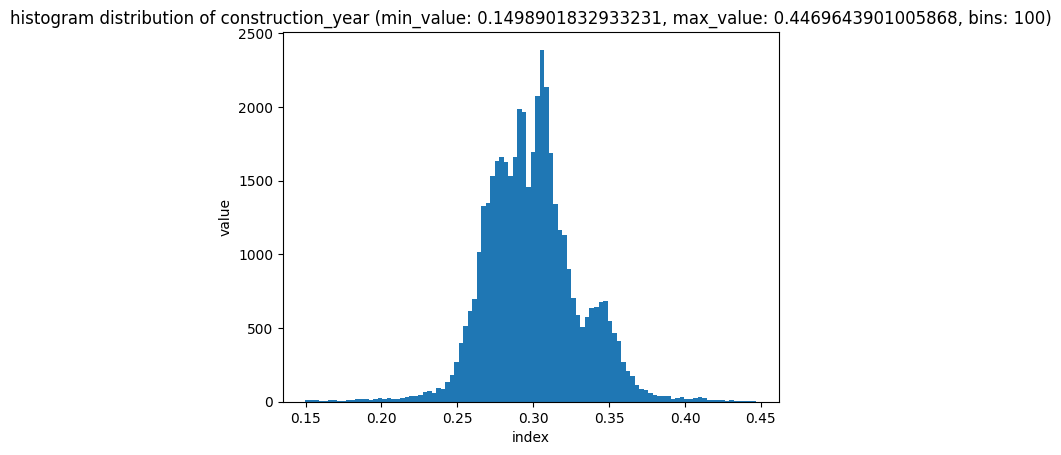

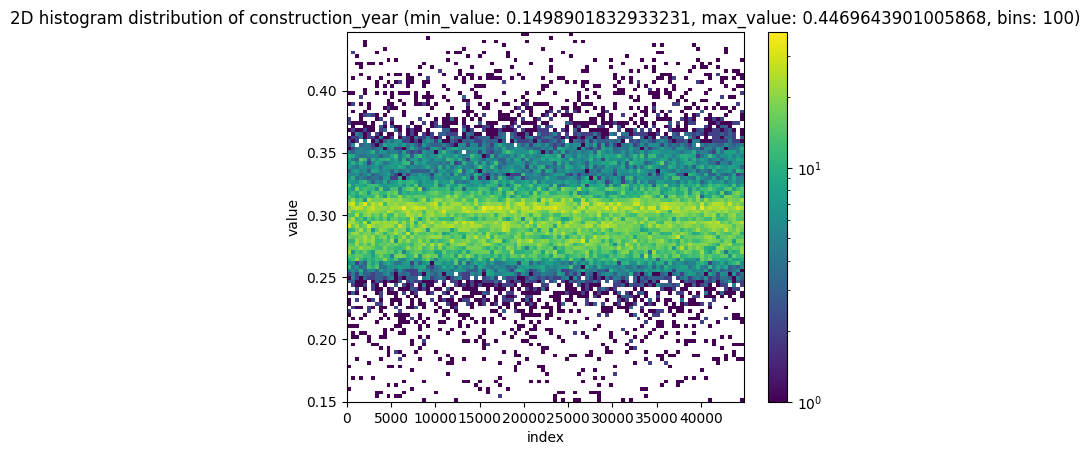

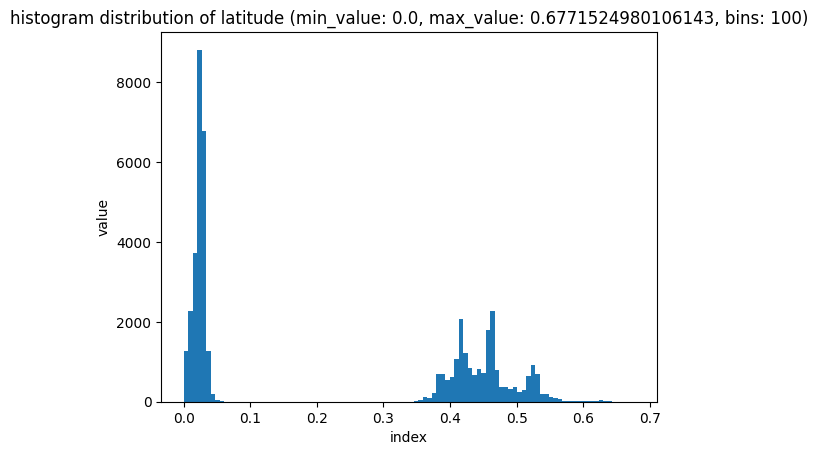

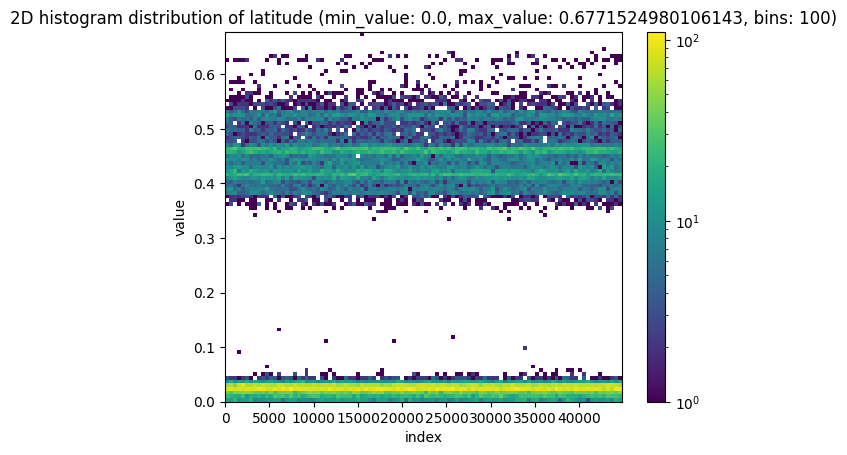

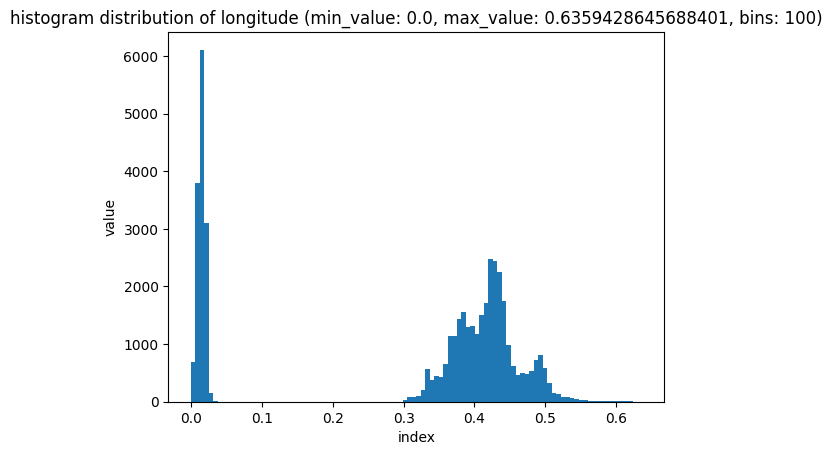

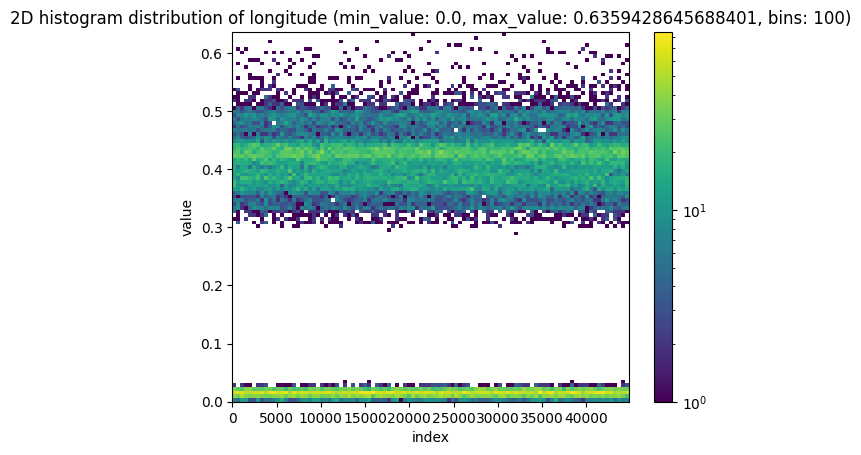

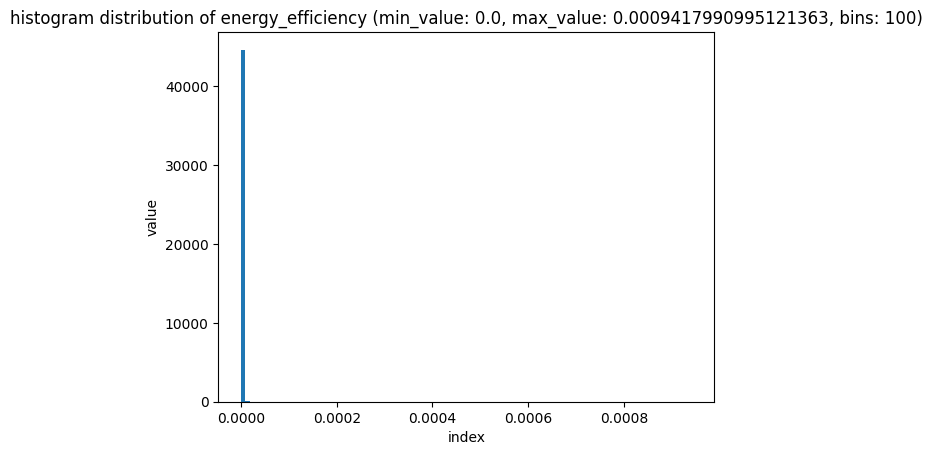

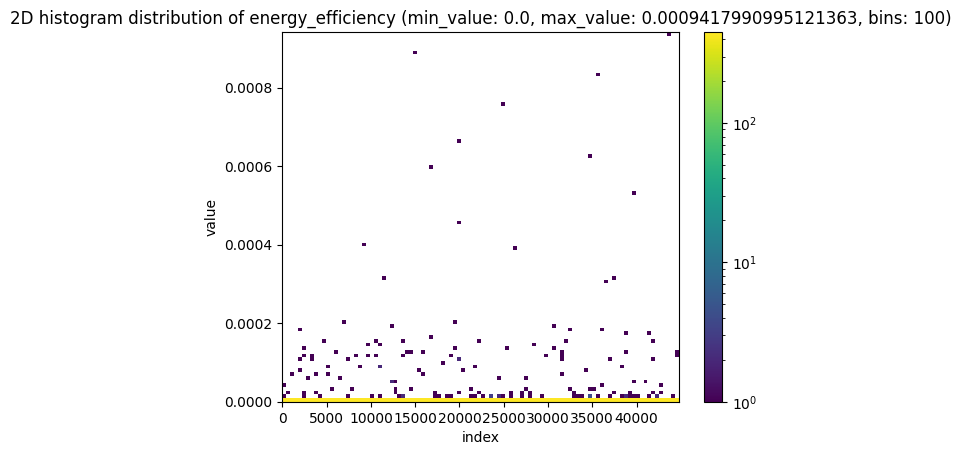

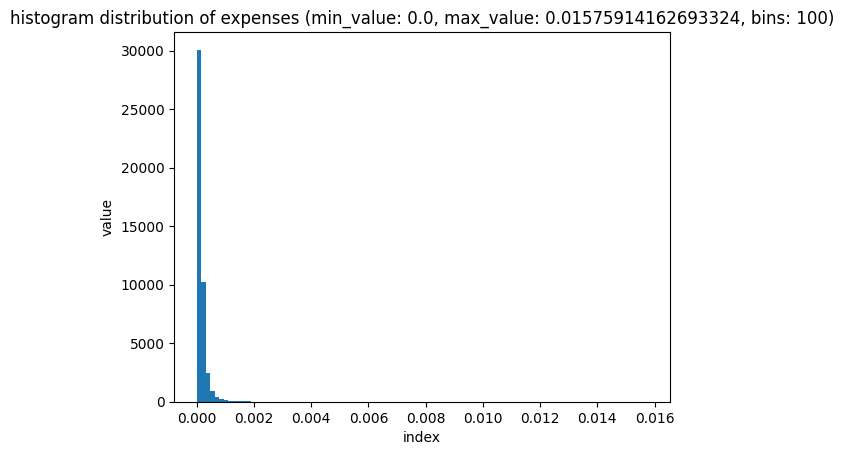

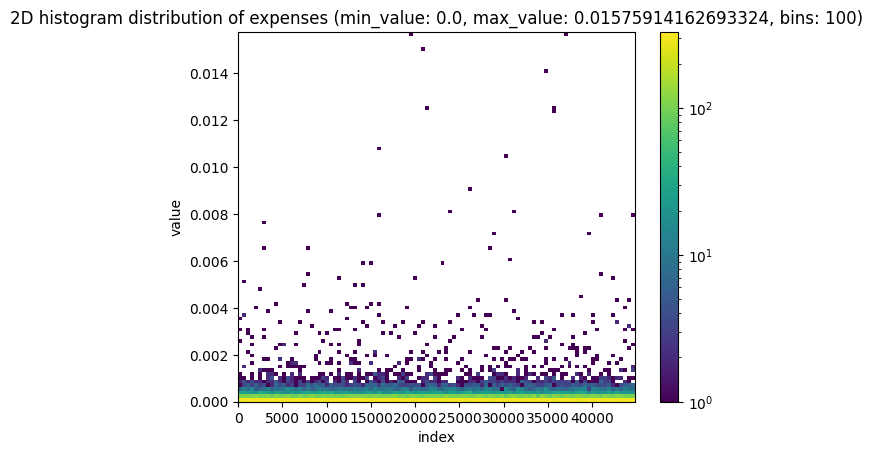

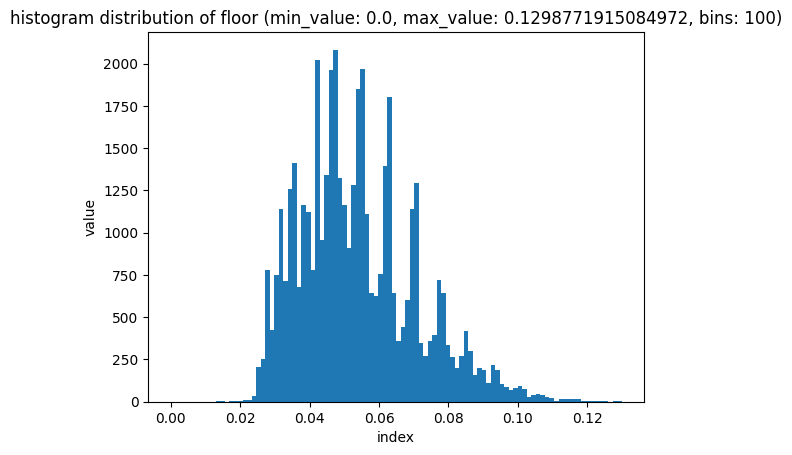

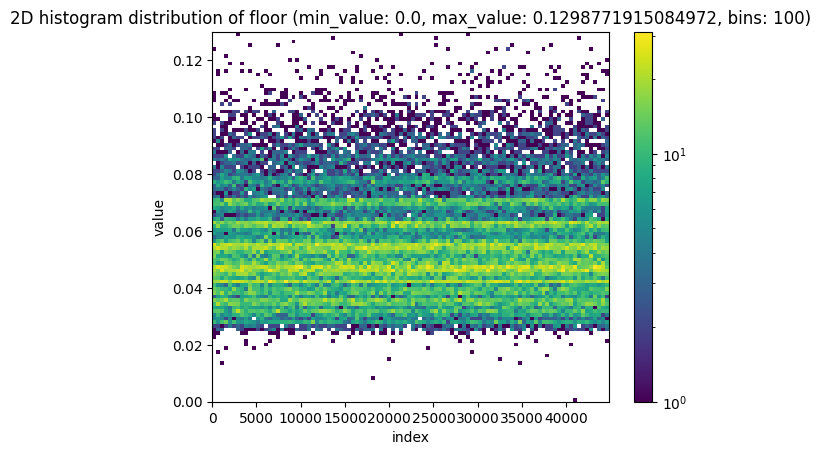

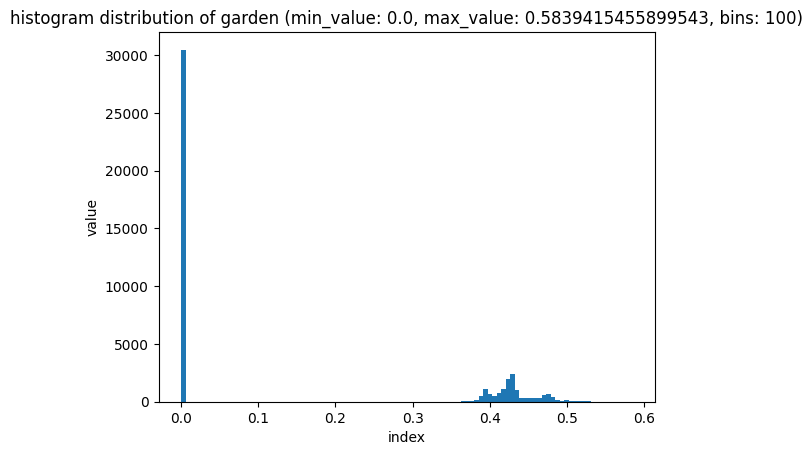

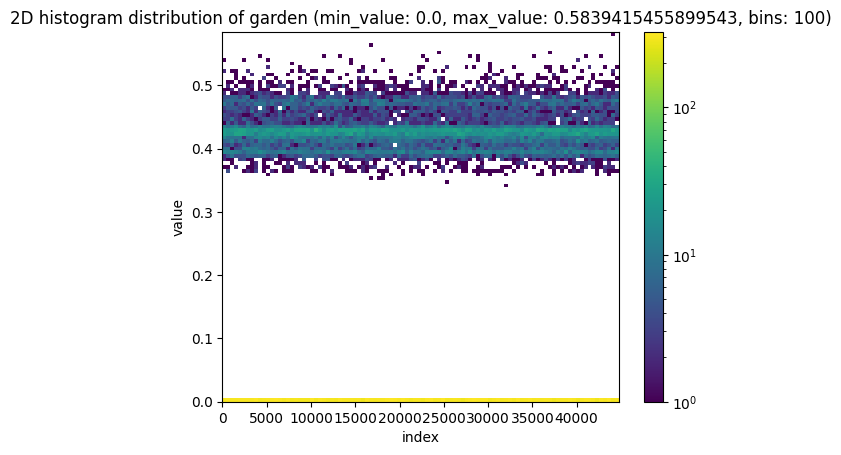

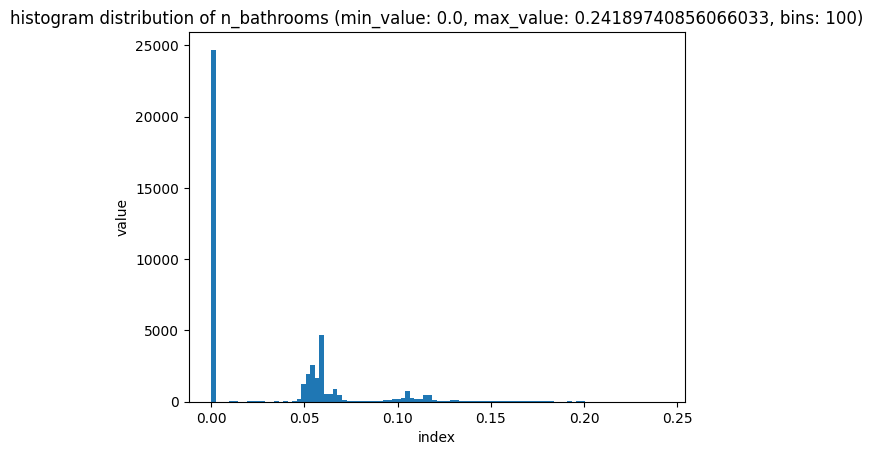

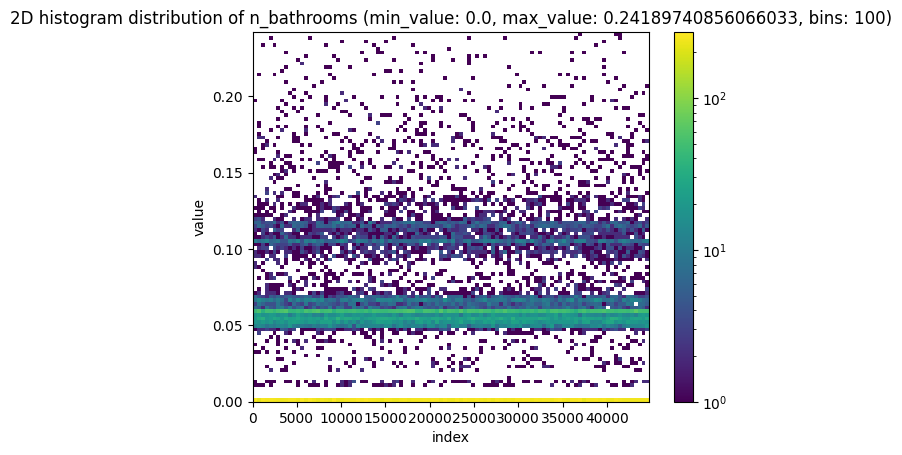

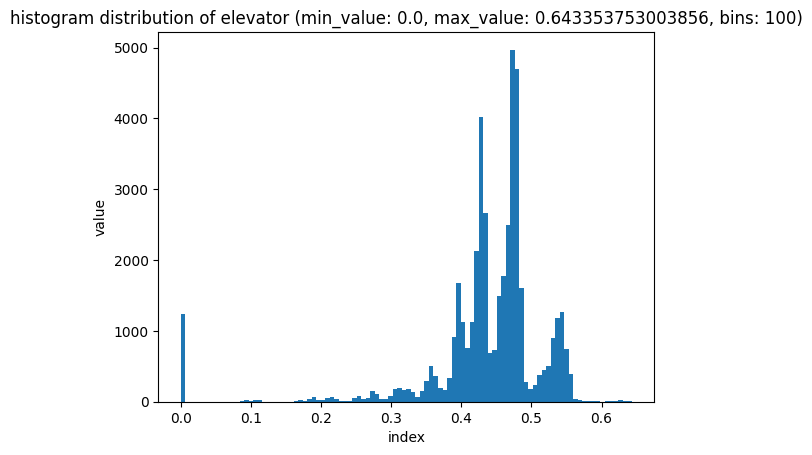

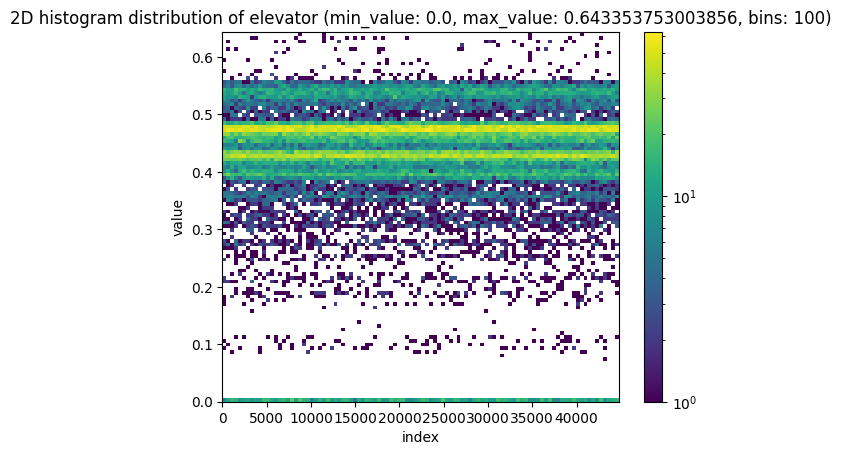

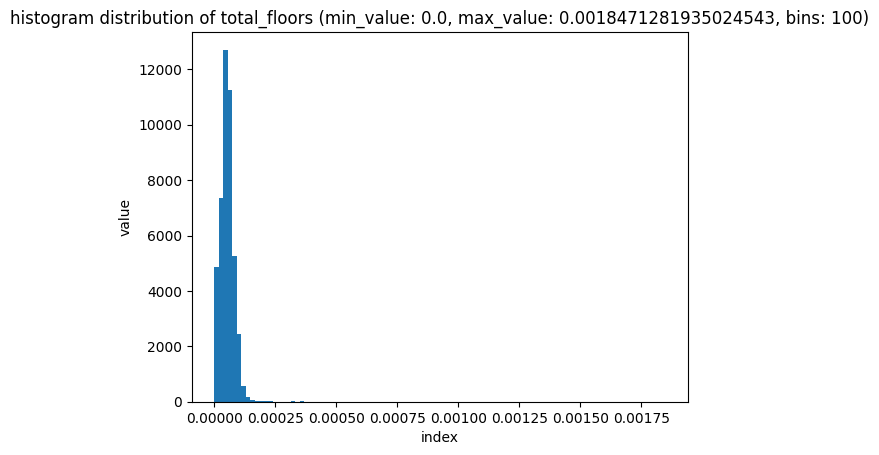

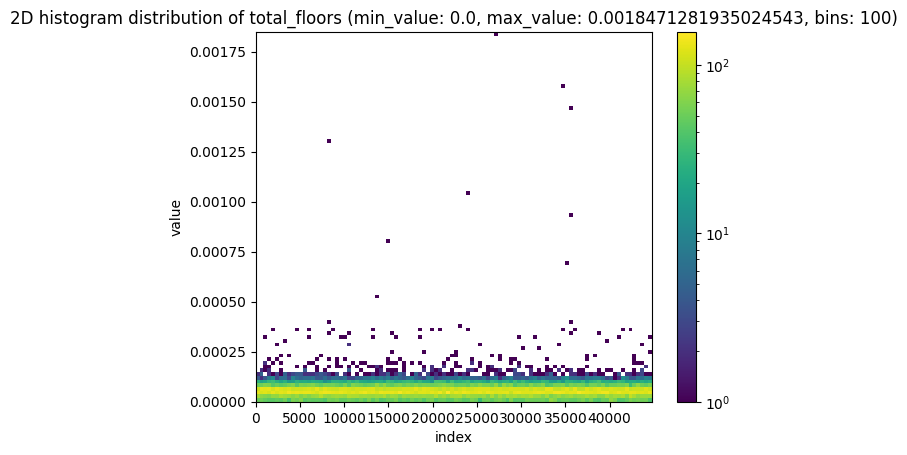

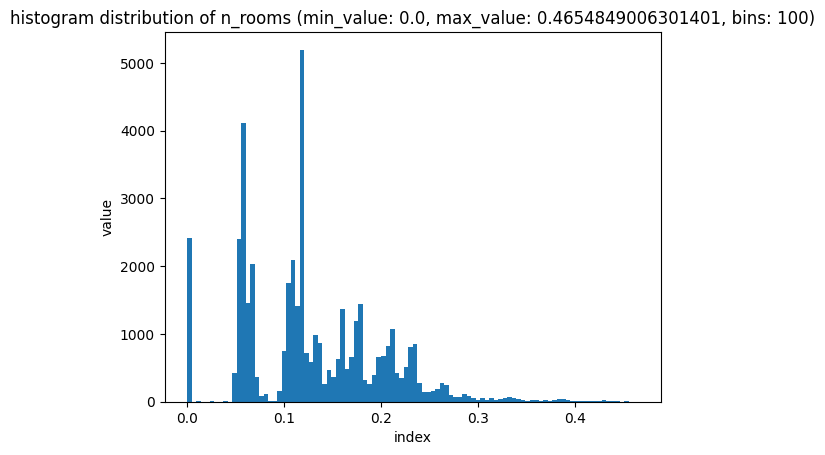

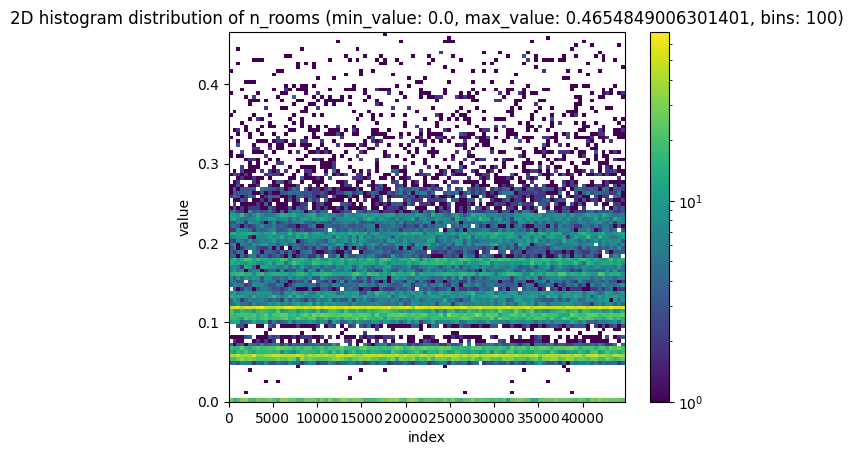

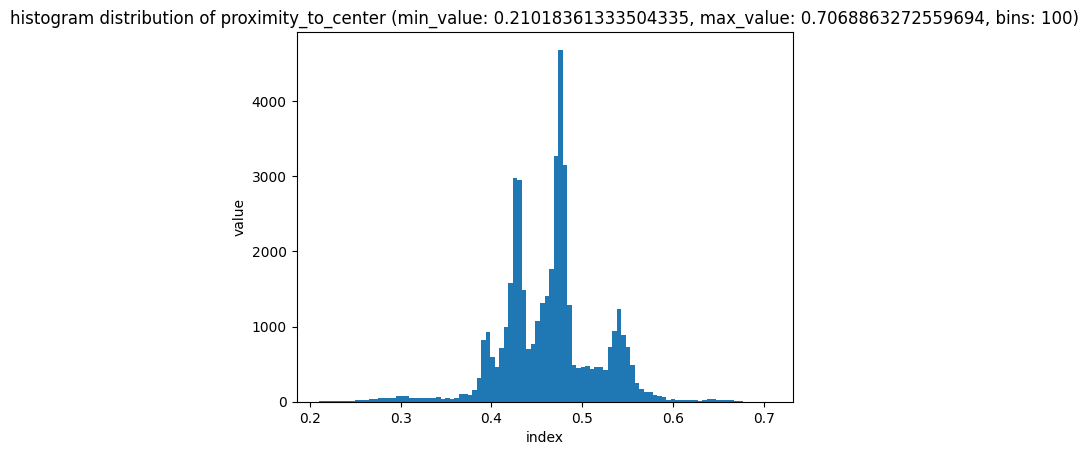

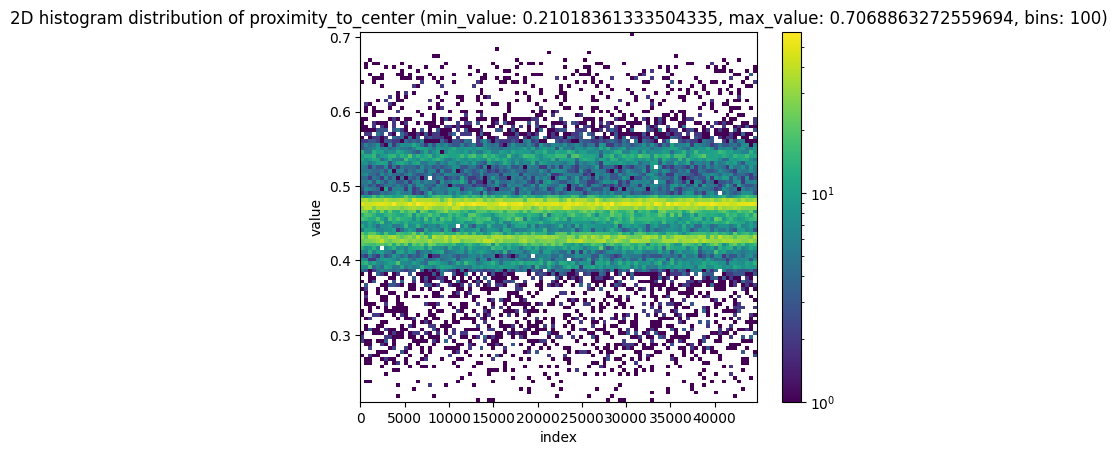

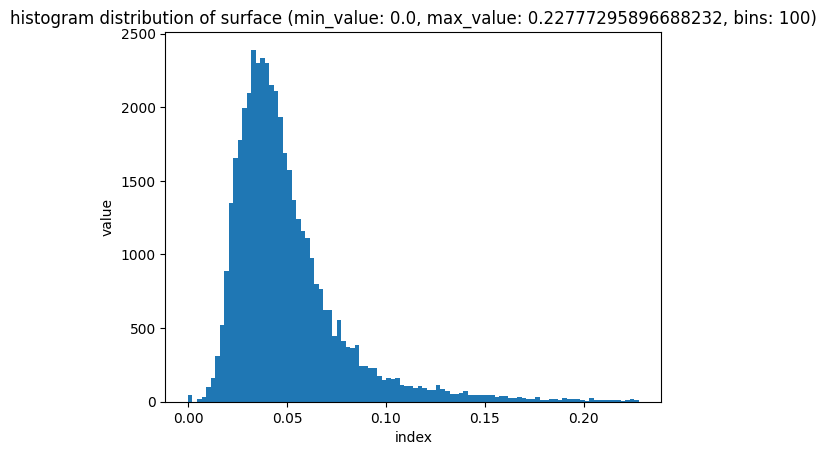

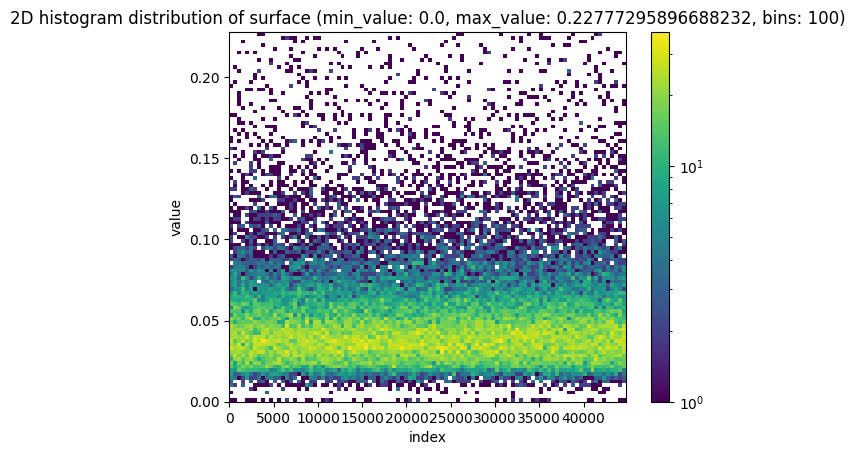

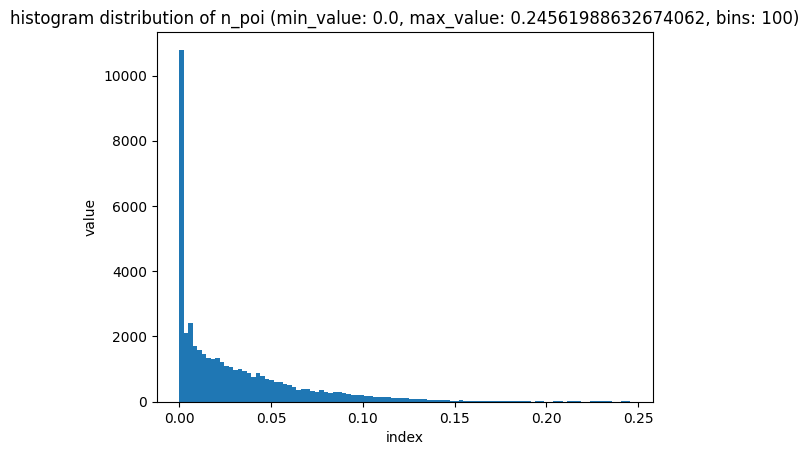

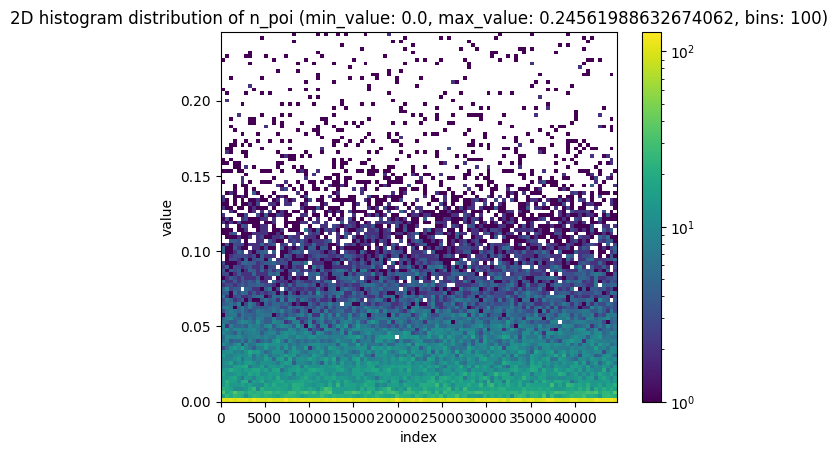

In [42]:
for col in train_df.columns:
    get_hist(train_df, col)

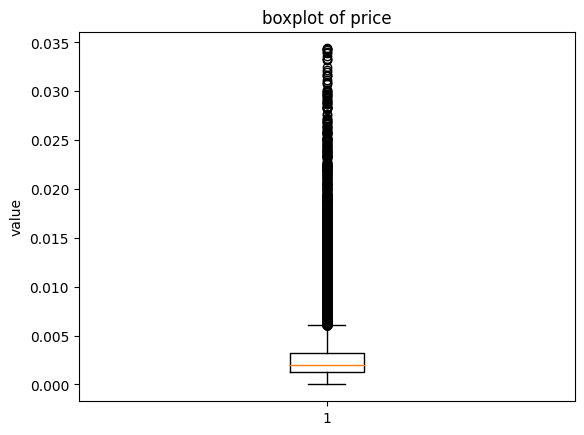

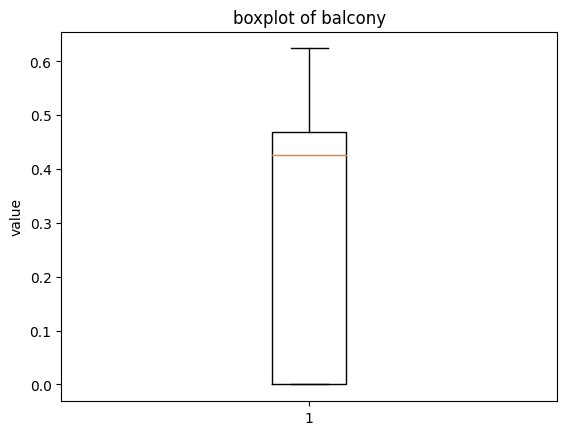

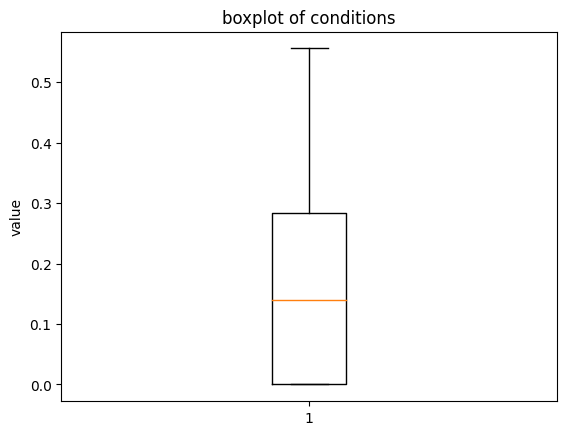

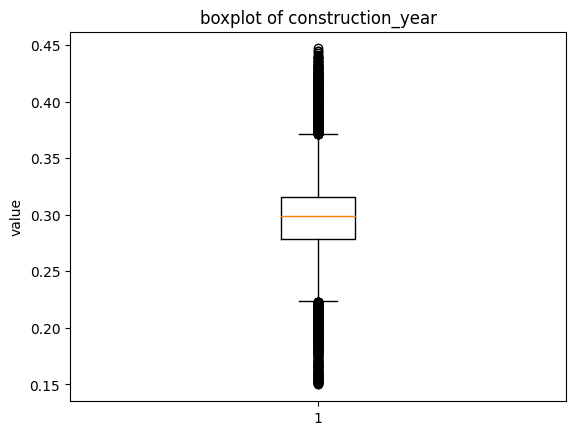

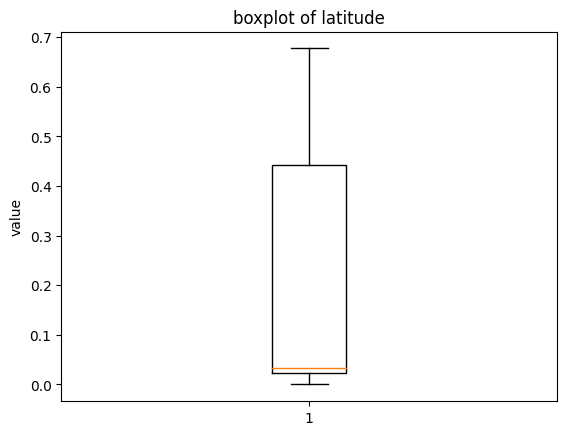

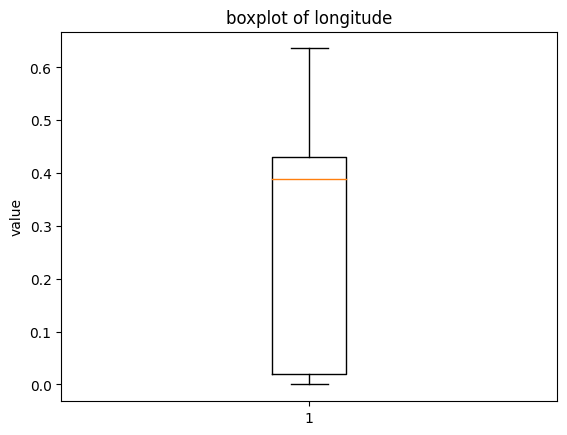

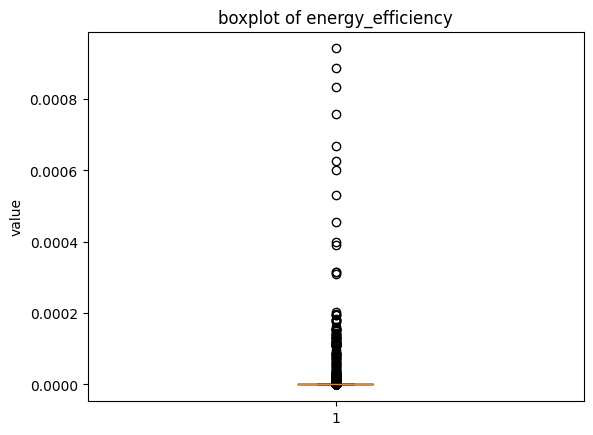

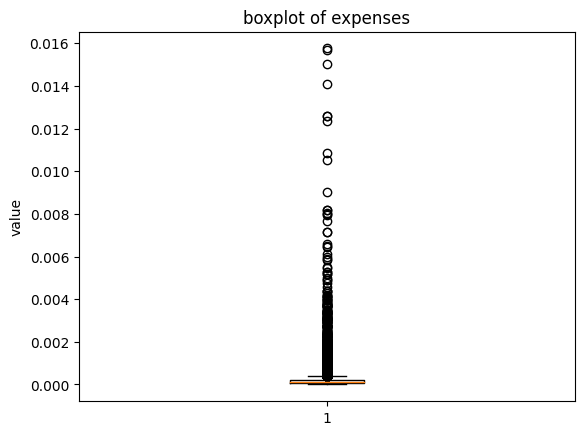

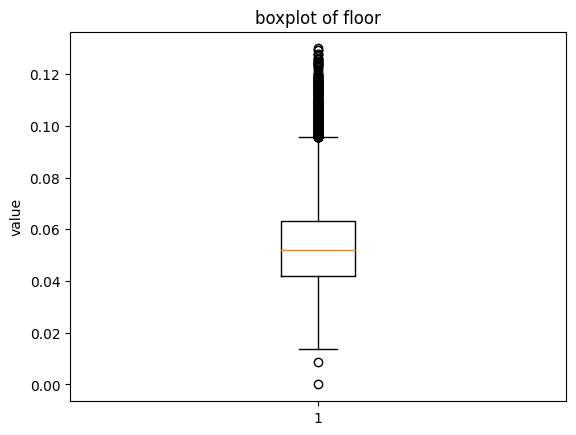

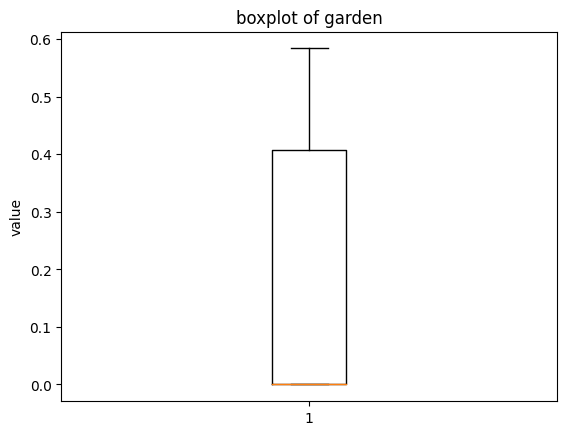

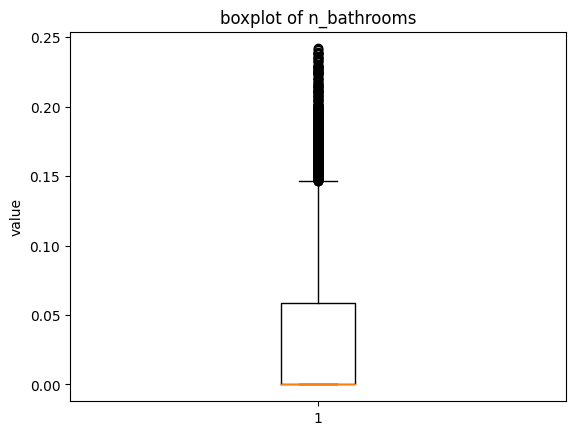

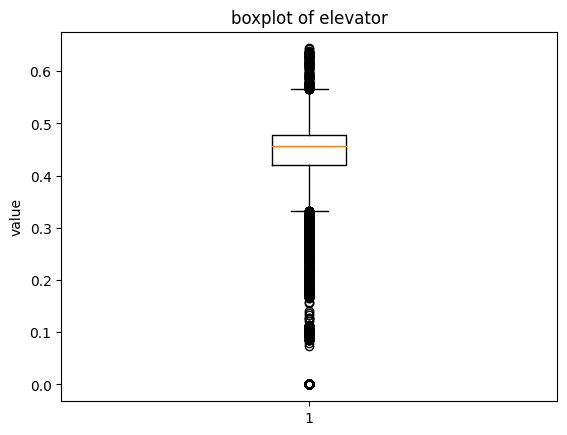

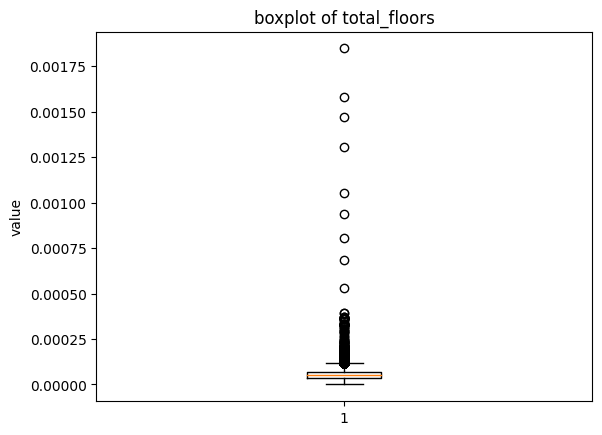

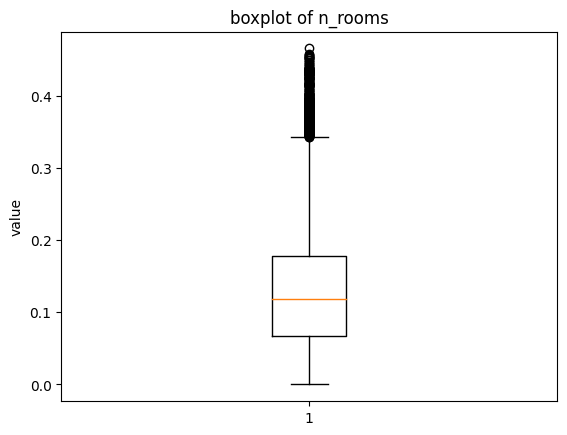

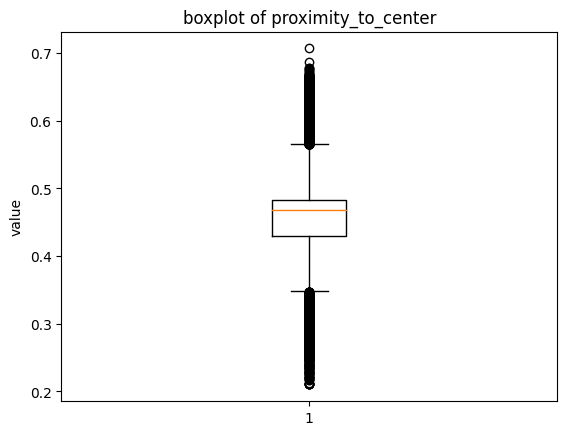

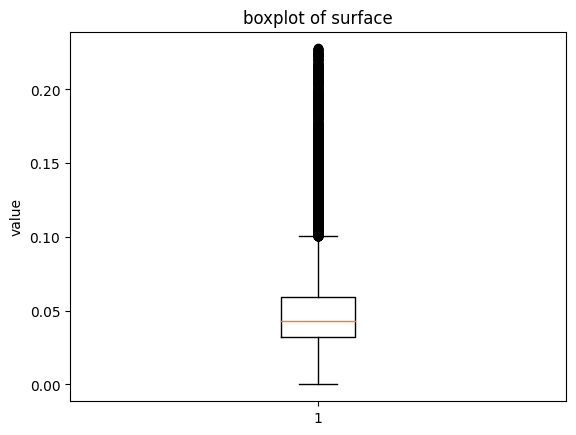

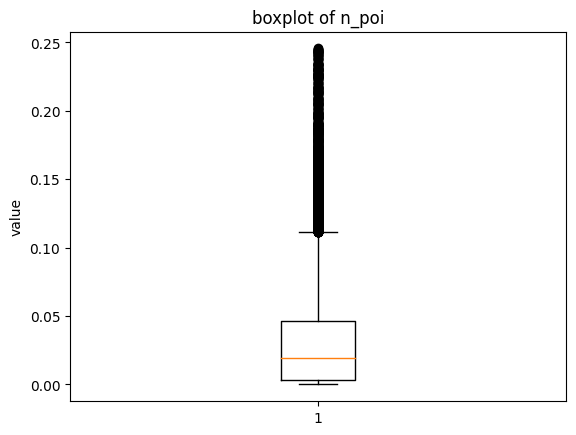

In [43]:
for col in train_df.columns:
    boxplot(train_df, col)

# 3. Feature importance analysis

- may drop features that are not relevant for our model 


In [44]:
train_df

price   balcony  conditions  construction_year  latitude  longitude   
0      0.000398  0.478659    0.000000           0.312724  0.026091   0.459214  \
1      0.006908  0.000000    0.000000           0.329813  0.030946   0.498436   
2      0.000269  0.000000    0.000000           0.377720  0.043635   0.525837   
3      0.001011  0.000000    0.146280           0.290863  0.430167   0.362960   
4      0.002494  0.438067    0.000000           0.288482  0.422584   0.377383   
...         ...       ...         ...                ...       ...        ...   
46307  0.002316  0.505599    0.000000           0.313135  0.030459   0.451218   
46308  0.003733  0.448798    0.299199           0.275263  0.026253   0.401571   
46309  0.003595  0.471652    0.000000           0.304562  0.458664   0.022621   
46310  0.001125  0.428998    0.000000           0.275989  0.416177   0.020941   
46311  0.002328  0.472354    0.157451           0.305455  0.022782   0.419718   

       energy_efficiency  expenses     floor    garden  n_bathrooms  elevator   
0           6.784588e-07  0.000042  0.054928  0.000000     0.000000  0.478659  \
1           5.249947e-07  0.000217  0.072493  0.000000     0.000000  0.552759   
2           9.761317e-07  0.000051  0.087077  0.000000     0.000000  0.472150   
3           6.220182e-07  0.000044  0.043165  0.438839     0.000000  0.438839   
4           2.338356e-07  0.000162  0.057451  0.000000     0.054758  0.438067   
...                  ...       ...       ...       ...          ...       ...   
46307       7.166449e-07  0.000051  0.066308  0.000000     0.000000  0.404479   
46308       5.129060e-07  0.000221  0.080931  0.000000     0.056100  0.448798   
46309       4.095214e-07  0.000227  0.077320  0.000000     0.058957  0.471652   
46310       6.350897e-07  0.000186  0.028131  0.428998     0.000000  0.428998   
46311       6.695218e-07  0.000137  0.046461  0.000000     0.000000  0.472354   

       total_floors   n_rooms  proximity_to_center   surface     n_poi  
0          0.000030  0.000000             0.478659  0.016922  0.000000  
1          0.000073  0.138190             0.552759  0.073143  0.031525  
2          0.000055  0.000000             0.590187  0.009538  0.000000  
3          0.000000  0.054855             0.430371  0.044327  0.000000  
4          0.000055  0.109517             0.438067  0.039824  0.013735  
...             ...       ...                  ...       ...       ...  
46307      0.000047  0.126400             0.505599  0.044942  0.012531  
46308      0.000065  0.224399             0.448798  0.085680  0.033100  
46309      0.000080  0.117913             0.471652  0.066698  0.034223  
46310      0.000051  0.107250             0.428998  0.030333  0.028566  
46311      0.000059  0.177133             0.472354  0.048190  0.002821  

[44824 rows x 17 columns]

With the random forest regressor we will compute the features importance.

In [45]:
# create x, y
x = train_df.drop('price', axis=1)
y = train_df['price']

In [46]:
from sklearn.ensemble import RandomForestRegressor

# compute feature_importances
rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(x, y)
sorted(rf.feature_importances_, reverse=True)

[0.4421314416394371,
 0.17883925950442023,
 0.10487284539738669,
 0.06144206802882555,
 0.03701028027786055,
 0.028638118487984598,
 0.026719641660122376,
 0.021340527273652436,
 0.018634866035849292,
 0.017655854295811277,
 0.017206228384028008,
 0.013966023192770823,
 0.010703869384481288,
 0.010010532714045053,
 0.007757115146082575,
 0.003071328577242244]

<BarContainer object of 16 artists>

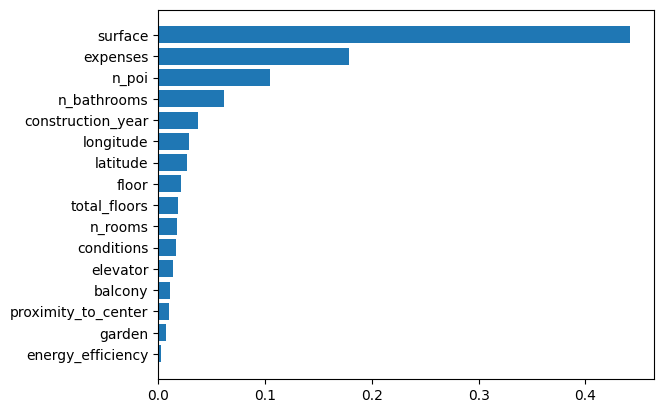

In [47]:
# plot feature_importances
sorted_idx = rf.feature_importances_.argsort()
plt.barh(x.columns[sorted_idx], rf.feature_importances_[sorted_idx])

We notice that the elevator is th efeature with least importance, we could drop it, but given the fact we have only 17 features we are going to keep it. 

In [48]:
train_df.drop(['elevator', 'balcony', 'garden', 'proximity_to_center'], axis=1, inplace=True)

# 5. Add Samples (Oversampling)

- in the case of regression we do not need to undersampling
- quindi facciamo oversampling aumentando i samples sinteticamente con funzioni apposite (SMOTE)
- oppure tramite integrazione di nuovi samples non sintetici da internet

In [49]:
'''
import smogn
train_df.reset_index(drop=True, inplace=True)
train_df_smogn = smogn.smoter(data=train_df, y='price', k=3)
'''
pass

# 5. Training

- creare tutti i regressor possibili e trainarli

In [50]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor

models = {
    'LinearRegression': LinearRegression(),
    'Ridge': Ridge(),
    'Lasso': Lasso(),
    'ElasticNet': ElasticNet(),
    'RandomForestRegressor': RandomForestRegressor(),
    'GradientBoostingRegressor': GradientBoostingRegressor(),
    'KNeighborsRegressor': KNeighborsRegressor(),
    'DecisionTreeRegressor': DecisionTreeRegressor(),
    'MLPRegressor': MLPRegressor()
}

In [51]:
train_df.reset_index(drop=True, inplace=True)
x = train_df.drop('price', axis=1)
y = train_df['price']

In [52]:
for model_name, model in models.items():
    print('model: {}'.format(model_name))
    model.fit(x, y)

model: LinearRegression
model: Ridge
model: Lasso
model: ElasticNet
model: RandomForestRegressor
model: GradientBoostingRegressor
model: KNeighborsRegressor
model: DecisionTreeRegressor
model: MLPRegressor


# 6. Prediction test_df 
- performiamo i modelli trainati sul test set e quindi otteniamo le prediction per kaggle

In [53]:
def test_df_preprocessing(test_df, map_conditions, imputer, scaler, normalizer):
    test_df['n_poi'] = test_df.apply(lambda x: get_n_poi(x['latitude'], x['longitude'], poi_df), axis=1)
    test_df['garden'] = test_df['garden'].fillna(False)
    test_df['balcony'] = test_df['balcony'].fillna(False)
    test_df['garden'] = test_df['garden'].apply(lambda x: 1 if x == True else 0)
    test_df['balcony'] = test_df['balcony'].apply(lambda x: 1 if x == True else 0)
    test_df['conditions'] = test_df['conditions'].apply(lambda x: map_conditions[x])
    test_df['conditions'] = test_df['conditions'].apply(lambda x: np.nan if x == map_conditions[np.nan] else x)
    test_df = pd.DataFrame(imputer.fit_transform(test_df), columns=test_df.columns)
    test_df.drop(['elevator', 'balcony', 'garden', 'proximity_to_center'], axis=1, inplace=True)
    test_df = pd.DataFrame(scaler.fit_transform(test_df), columns=test_df.columns)
    test_df = pd.DataFrame(normalizer.fit_transform(test_df), columns=test_df.columns)
    return test_df

In [54]:
test_df = test_df_preprocessing(test_df, map_conditions, imputer, scaler, normalizer)

In [55]:
def submission(model, test_df, filename):
    submission_df = test_df['id'].to_frame()
    # get predictions and save them in submission_df as 'price' column (in the right format for the submission)
    submission_df['price'] = model.predict(test_df.drop('id', axis=1))
    submission_df['id'] = submission_df['id'].astype(int)
    submission_df.to_csv(filename, index=False)
    return

In [57]:
for model_name, model in models.items():
    submission(model, test_df, 'submission_{}.csv'.format(model_name))

In [58]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
def evaluate_model(model, x, y):
    MAE_scores = cross_val_score(model, x, y, scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)
    MSE_scores = cross_val_score(model, x, y, scoring='neg_mean_squared_error', cv=5, n_jobs=-1)
    # plot
    y_pred = cross_val_predict(model, x, y, cv=5, n_jobs=-1)
    plt.scatter(y, y_pred, alpha=0.5)
    plt.plot([0, max(y.max(), y_pred.max())], [0, max(y.max(), y_pred.max())], 'r--', lw=2)
    plt.xlabel('True price')
    plt.ylabel('Predicted price')
    plt.title('{}'.format(model))
    plt.show()
    plt.close()
    print('MAE: {:.3f} ({:.3f})'.format(-MAE_scores.mean(), MAE_scores.std()))
    print('MSE: {:.3f} ({:.3f})'.format(-MAE_scores.mean(), MAE_scores.std()))
    return MAE_scores, MSE_scores

In [59]:
performance = {model_name: {'MSE_mean': 0.0, 'MSE_std': 0.0, 'MAE_mean': 0.0, 'MAE_std': 0.0} for model_name in models.keys()}

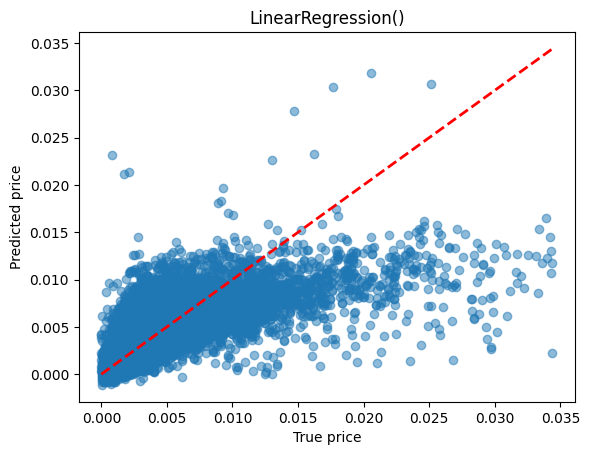

MAE: 0.001 (0.000)
MSE: 0.001 (0.000)


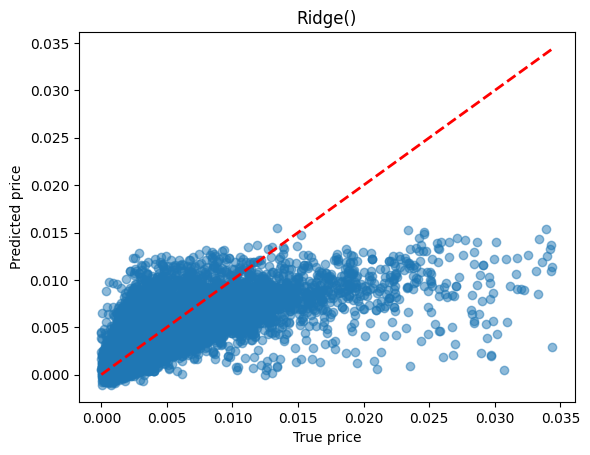

MAE: 0.001 (0.000)
MSE: 0.001 (0.000)


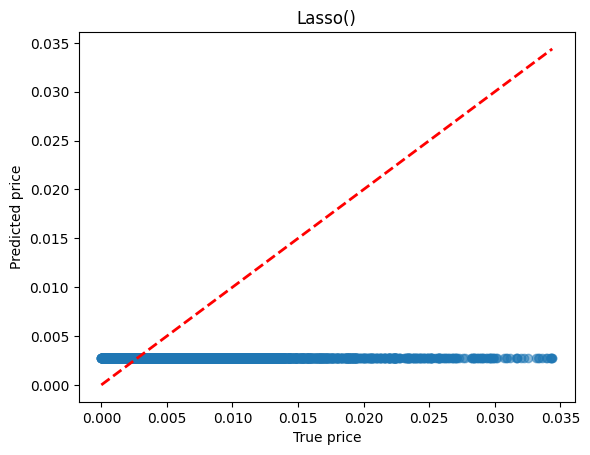

MAE: 0.002 (0.000)
MSE: 0.002 (0.000)


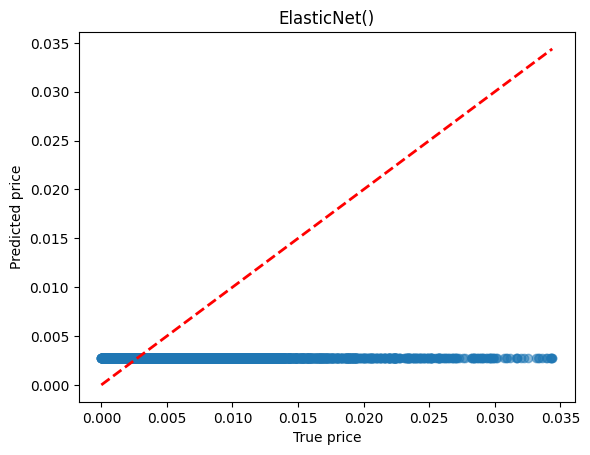

MAE: 0.002 (0.000)
MSE: 0.002 (0.000)


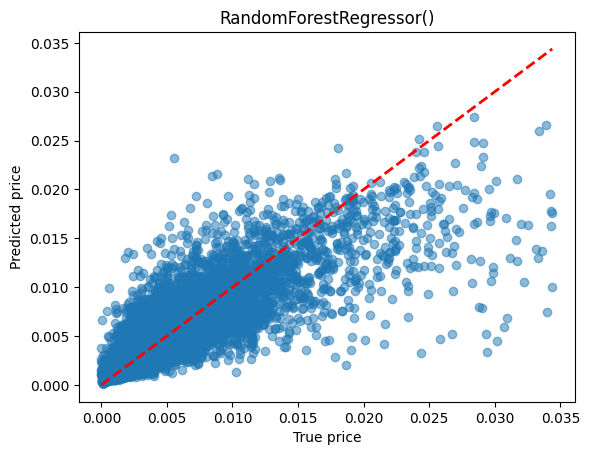

MAE: 0.001 (0.000)
MSE: 0.001 (0.000)


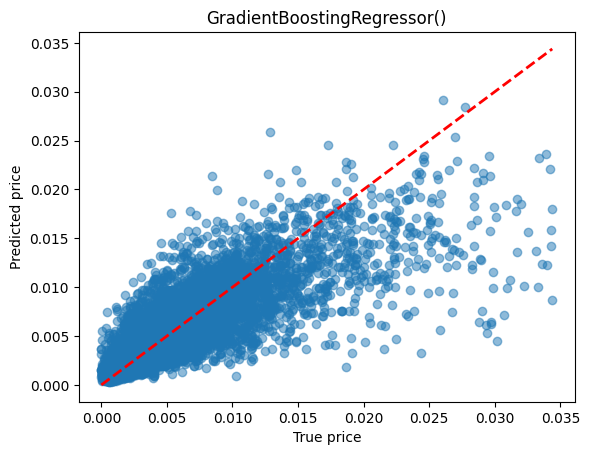

MAE: 0.001 (0.000)
MSE: 0.001 (0.000)


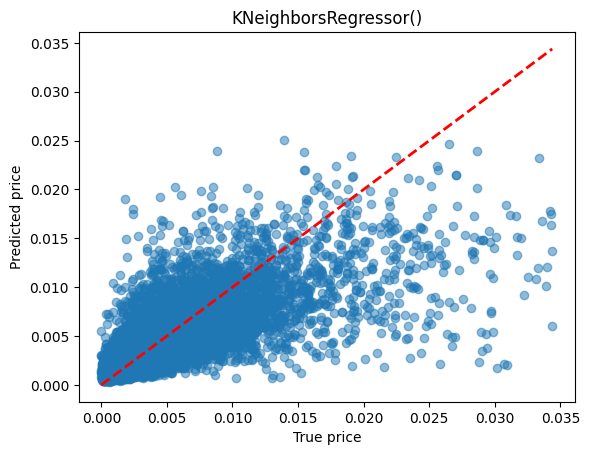

MAE: 0.001 (0.000)
MSE: 0.001 (0.000)


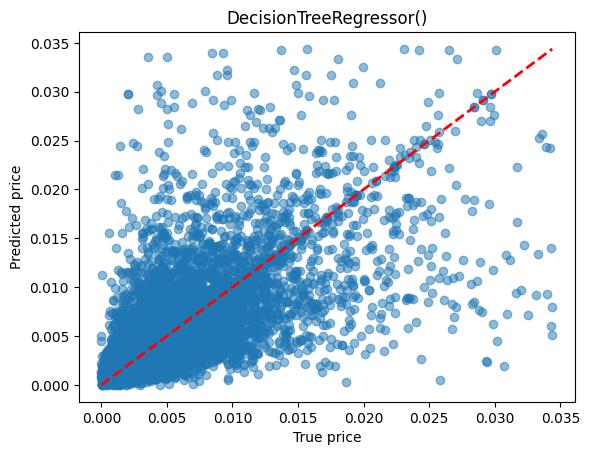

MAE: 0.001 (0.000)
MSE: 0.001 (0.000)


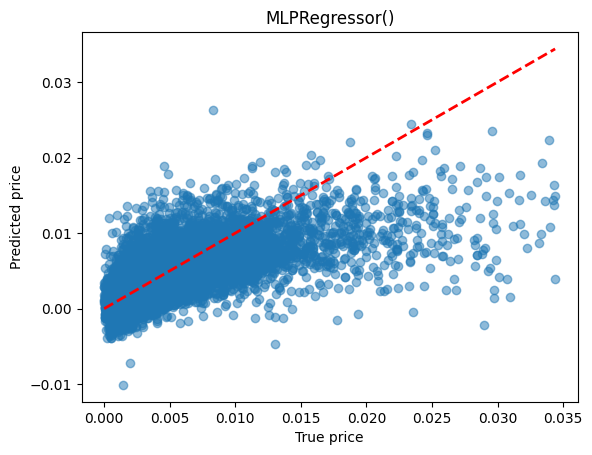

MAE: 0.001 (0.000)
MSE: 0.001 (0.000)


In [60]:
for model_name, model in models.items():
    MAE_scores, MSE_scores = evaluate_model(model, x, y)
    performance[model_name]['MAE_mean'] = -MAE_scores.mean()
    performance[model_name]['MAE_std'] = MAE_scores.std()
    performance[model_name]['MSE_mean'] = -MSE_scores.mean()
    performance[model_name]['MSE_std'] = MSE_scores.std()

In [61]:
performance_df = pd.DataFrame.from_dict(performance, orient='index').sort_values(by='MSE_mean').reset_index().rename(columns={'index': 'model'})
performance_df

model  MSE_mean       MSE_std  MAE_mean   MAE_std
0      RandomForestRegressor  0.000002  2.226166e-07  0.000658  0.000017
1  GradientBoostingRegressor  0.000002  1.979802e-07  0.000769  0.000014
2        KNeighborsRegressor  0.000003  2.934203e-07  0.000835  0.000020
3           LinearRegression  0.000003  3.158342e-07  0.001037  0.000017
4                      Ridge  0.000004  2.899834e-07  0.001074  0.000017
5      DecisionTreeRegressor  0.000004  3.545128e-07  0.000910  0.000020
6               MLPRegressor  0.000004  4.644471e-07  0.001361  0.000214
7                      Lasso  0.000008  3.630344e-07  0.001684  0.000013
8                 ElasticNet  0.000008  3.630344e-07  0.001684  0.000013

# 7. Tuning

- troviamo la combinazione di iperparametri migliori per il modello migliore che abbiamo fino ad ora ottenuto
- quindi accordiamo il modello migliore

In [62]:
# tuning random forest regressor
from sklearn.model_selection import GridSearchCV
param_grid = {
    'n_estimators': [200, 400, 600],
    'max_depth': [None, 10, 15],
    'max_features': [None, 'sqrt', 'log2'],
    'bootstrap': [True, False]
}
rf = RandomForestRegressor(random_state=42, n_jobs=-1)
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, scoring='neg_mean_squared_error', cv=3, n_jobs=-1, verbose=2)
grid_search.fit(x, y)
grid_search.best_params_

Fitting 3 folds for each of 54 candidates, totalling 162 fits
[CV] END bootstrap=True, max_depth=None, max_features=log2, n_estimators=200; total time=  20.8s
[CV] END bootstrap=True, max_depth=None, max_features=log2, n_estimators=200; total time=  22.4s
[CV] END bootstrap=True, max_depth=None, max_features=log2, n_estimators=200; total time=  22.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, n_estimators=200; total time=  23.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, n_estimators=200; total time=  24.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, n_estimators=200; total time=  24.6s
[CV] END bootstrap=True, max_depth=10, max_features=None, n_estimators=200; total time=  39.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, n_estimators=400; total time=  39.2s
[CV] END bootstrap=True, max_depth=10, max_features=None, n_estimators=200; total time=  40.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, n_estimat

/home/vincenzo/.anaconda3/envs/stable/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=10, max_features=log2, n_estimators=200; total time=  14.0s
[CV] END bootstrap=True, max_depth=10, max_features=log2, n_estimators=200; total time=  15.0s
[CV] END bootstrap=True, max_depth=None, max_features=log2, n_estimators=600; total time=  57.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, n_estimators=600; total time=  58.1s
[CV] END bootstrap=True, max_depth=10, max_features=log2, n_estimators=200; total time=  16.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, n_estimators=600; total time=  58.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, n_estimators=600; total time=  59.4s
[CV] END bootstrap=True, max_depth=None, max_features=log2, n_estimators=600; total time=  59.5s
[CV] END bootstrap=True, max_depth=None, max_features=None, n_estimators=200; total time=  59.9s
[CV] END bootstrap=True, max_depth=None, max_features=log2, n_estimators=600; total time=  59.9s
[CV] END bootstrap=True, max_depth=N

{'bootstrap': False,
 'max_depth': None,
 'max_features': 'sqrt',
 'n_estimators': 600}

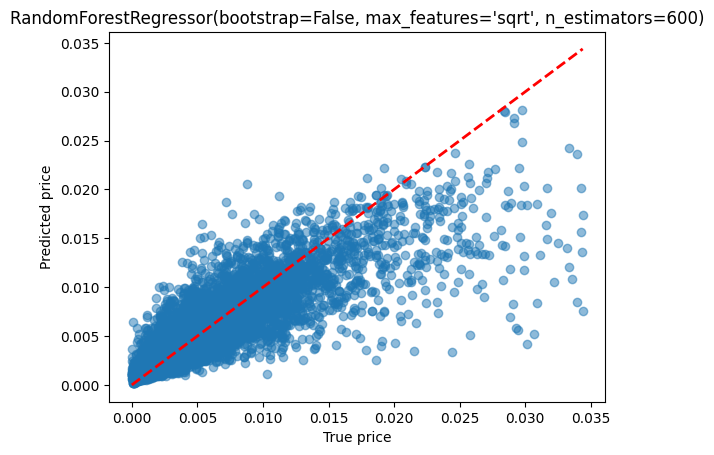

MAE: 0.001 (0.000)
MSE: 0.001 (0.000)
MAE: 0.001 (0.000 std)
MSE: 0.000 (0.000 std)


In [63]:
tuned_model = RandomForestRegressor(**grid_search.best_params_)
tuned_model.fit(x, y)
MAE_score, MSE_score = evaluate_model(tuned_model, x, y)
print('MAE: {:.3f} ({:.3f} std)'.format(-MAE_score.mean(), MAE_score.std()))
print('MSE: {:.3f} ({:.3f} std)'.format(-MSE_score.mean(), MSE_score.std()))

submission(tuned_model, test_df, 'submission_tuned_model.csv')